In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [2]:
conn = sqlite3.connect('web-performance.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements

,msm_id,timestamp,experiment_type,error,website
0,4d9357a5-e1f2-4bd0-b93b-89b674823a4b,2022-06-02_17_23_44,dsl,,www.example.org
1,74059a0d-575f-40ee-a052-6e5132421857,2022-06-02_17_24_37,cable,,www.example.org
2,3c786045-b634-4411-baf8-8b0a971c3990,2022-06-02_17_25_29,fiber,,www.example.org
3,cbcda8e8-ad10-43c0-958e-5489a4c290ec,2022-06-02_17_26_21,4g,,www.example.org
4,f27c87c4-7f84-4c78-b704-2d974296f98e,2022-06-02_17_27_14,4g-medium,,www.example.org
...,...,...,...,...,...
1237,855b622a-f150-4856-b28b-be190fbbc6e5,2022-06-03_12_16_24,4g-medium,,www.example.org
1238,4cf3882c-c8fe-46a7-b39b-cf2430f390ec,2022-06-03_12_17_17,dsl,,www.wikipedia.org
1239,9663053d-ef3f-4887-810b-63ea071e2f59,2022-06-03_12_18_10,cable,,www.wikipedia.org
1240,c1549680-2973-400c-a17a-61bcd7725f83,2022-06-03_12_19_03,fiber,,www.wikipedia.org


In [3]:
measurements.error.value_counts()

    1242
Name: error, dtype: int64

In [4]:
df_web_perf = pd.read_sql_query("SELECT * FROM web_performance_metrics", conn)
df_dns_perf = pd.read_sql_query("SELECT * FROM dns_metrics", conn)
df_lookups = pd.read_sql_query("SELECT * FROM lookups", conn)
conn.close()

In [5]:
df_web_perf = pd.merge(df_web_perf, measurements, on='msm_id')

In [6]:
df_web_perf.groupby(['website', 'is_warmup']).agg(plt=('loadEventEnd', 'median'),fp=('firstPaint', 'median'))

plt      fp
website           is_warmup                 
www.example.org   0           106.95  118.00
                  1           229.65  232.05
www.instagram.com 0           381.10  145.50
                  1          5797.25  238.95
www.wikipedia.org 0           142.35  122.90
                  1           619.50  406.85

In [7]:
df_dns_perf_metrics = df_dns_perf.copy()

In [8]:
df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].replace({'metrics:DoUDP UDP setup duration from': 'metrics:DoUDP UDP setup duration from '}, regex=True)

df_dns_perf_metrics['metric_type'] = "none"
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("setup duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("exchange duration"), "exchange", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("query duration"), "query", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("handshake duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("DoH query"), "lazy-init-handshake-and-query", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics.metric.str.split(' ').str[-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-2]

df_dns_perf_metrics['base'] = 1000
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'm', 1, df_dns_perf_metrics['base'])
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics['base'])

df_dns_perf_metrics['duration'] = np.where((df_dns_perf_metrics.duration.str[-1] != 'm') & (df_dns_perf_metrics.duration.str[-1] != 'µ'), df_dns_perf_metrics['duration']+'s', df_dns_perf_metrics['duration'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].astype(float) * df_dns_perf_metrics['base']

df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].str[8:]

df_dns_perf_metrics['metric_start'] = df_dns_perf_metrics['metric'].str.extract(r'\sfrom\s(.*?)\sto\s')

df_dns_perf_metrics['metric_end'] = df_dns_perf_metrics['metric'].str.extract(r'\sto\s(.*?)\:\s')

df_dns_perf_metrics['protocol'] = df_dns_perf_metrics.metric.str.split(' ').str[0]

df_dns_perf_metrics['domain'] = df_dns_perf_metrics['metric'].str.extract(r'\sfor\s\[\;(.*?)\]\s')

df_dns_perf_metrics.metric_start = "2022 "+df_dns_perf_metrics.metric_start
df_dns_perf_metrics.metric_end = "2022 "+df_dns_perf_metrics.metric_end

df_dns_perf_metrics.metric_start = pd.to_datetime(df_dns_perf_metrics.metric_start, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.metric_end = pd.to_datetime(df_dns_perf_metrics.metric_end, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.domain = df_dns_perf_metrics.domain.str[:-7]

In [9]:
df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].groupby(['transport_protocol', 'is_warmup']).agg(lookup_dur=('duration','median'))

,,lookup_dur
transport_protocol,is_warmup,
DoH,0,206.117951
DoQ,0,153.775290
DoUDP,0,56.567909


In [10]:
df_exchange_times = df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].copy()

In [11]:
df_dns_and_h3 = pd.merge(df_web_perf, df_lookups[['msm_id', 'elapsed', 'transport_protocol']], on='msm_id')


In [22]:
df_dns_and_h3['full_plt'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['loadEventStart']
df_dns_and_h3['full_fp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstPaint']
df_dns_and_h3['full_fcp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstContentfulPaint']

In [23]:
df_dns_and_h3['h3_description'] = 'H3 1-RTT'
df_dns_and_h3['h3_description'] = np.where(df_dns_and_h3['is_warmup'] == 0, 'H3 0-RTT', df_dns_and_h3['h3_description'])

In [24]:
df_dns_and_h3.h3_description.value_counts() #thrice the actual value because of join

H3 0-RTT    3726
H3 1-RTT    3726
Name: h3_description, dtype: int64

In [25]:
df_dns_and_h3.transport_protocol.value_counts() #twice the actual value because of join

DoQ      2484
DoUDP    2484
DoH      2484
Name: transport_protocol, dtype: int64

In [26]:
df_dns_and_h3.website.value_counts()

www.example.org      2508
www.wikipedia.org    2484
www.instagram.com    2460
Name: website, dtype: int64

In [27]:
df_dns_and_h3.experiment_type.value_counts()

fiber        1494
cable        1494
dsl          1494
4g           1488
4g-medium    1482
Name: experiment_type, dtype: int64

In [28]:
df_dns_and_h3['experiment_description'] = df_dns_and_h3.transport_protocol + ' + ' + df_dns_and_h3.h3_description

In [29]:
df_dns_and_h3['experiment_description'].value_counts()

DoQ + H3 1-RTT      1242
DoUDP + H3 1-RTT    1242
DoUDP + H3 0-RTT    1242
DoQ + H3 0-RTT      1242
DoH + H3 1-RTT      1242
DoH + H3 0-RTT      1242
Name: experiment_description, dtype: int64

dsl
count     84.000000
mean     380.450196
std       52.361424
min      187.021549
10%      318.744236
20%      341.148942
25%      344.397647
30%      352.217127
40%      369.629597
50%      394.462063
60%      401.105812
70%      405.638447
75%      414.141700
80%      422.592252
90%      446.210754
100%     491.249233
max      491.249233
Name: full_plt, dtype: float64
count     84.000000
mean     258.847815
std       42.286491
min      177.415609
10%      198.689911
20%      224.381291
25%      230.346257
30%      234.761381
40%      246.445745
50%      253.636009
60%      271.296545
70%      288.087618
75%      293.445347
80%      297.940692
90%      313.060352
100%     350.470880
max      350.470880
Name: full_plt, dtype: float64
count     84.000000
mean     429.754230
std       63.530940
min      260.317289
10%      348.132453
20%      380.032335
25%      390.383713
30%      395.744523
40%      409.887213
50%      432.373142
60%      451.527238
70%      468.626116
75%      476.3

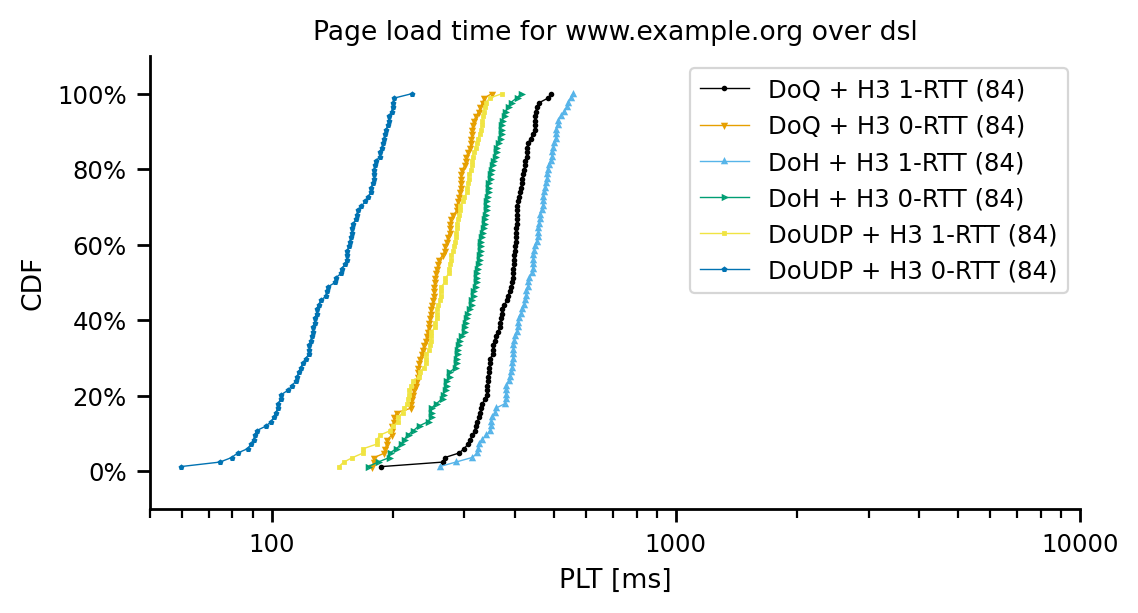

count     83.000000
mean     768.092113
std       58.375598
min      638.967175
10%      689.972954
20%      718.846614
25%      725.976757
30%      736.195013
40%      751.013709
50%      761.930043
60%      773.444305
70%      790.922620
75%      808.845907
80%      813.999608
90%      850.641825
100%     920.117989
max      920.117989
Name: full_plt, dtype: float64
count     83.000000
mean     287.404161
std       41.279451
min      194.827513
10%      233.992109
20%      252.457195
25%      261.401166
30%      266.329656
40%      272.856275
50%      284.791196
60%      299.333938
70%      311.626393
75%      316.072979
80%      324.868398
90%      343.350210
100%     368.115823
max      368.115823
Name: full_plt, dtype: float64
count      83.000000
mean      818.109865
std        67.317097
min       650.698889
10%       738.967769
20%       766.936145
25%       770.409494
30%       778.578598
40%       803.284463
50%       818.524536
60%       837.696915
70%       846.119152
75%   

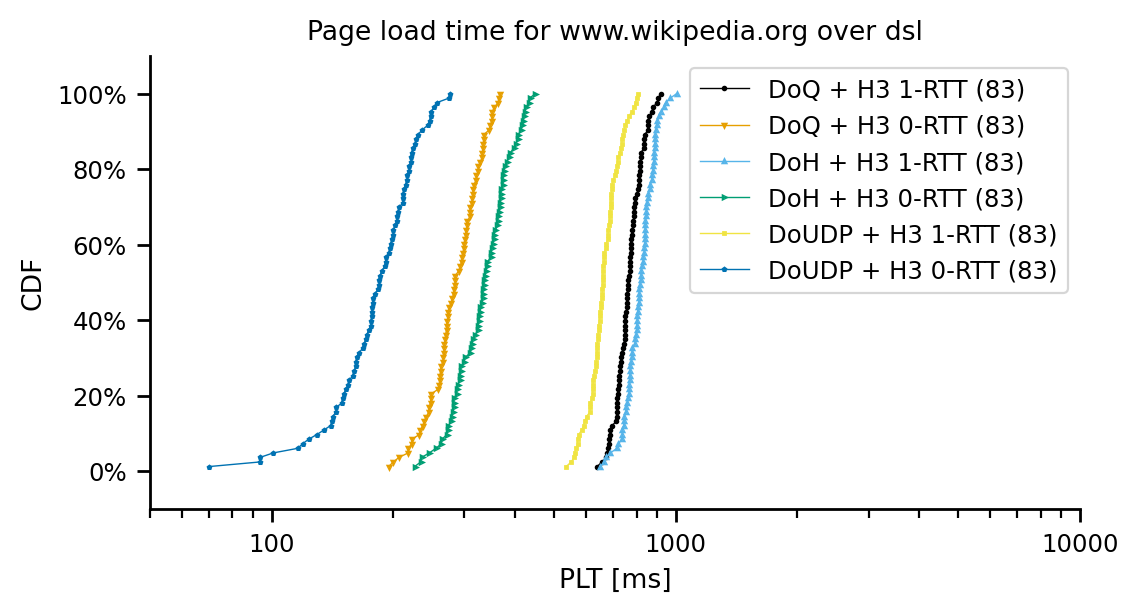

count      82.000000
mean     5927.015155
std       500.410502
min      4707.588342
10%      5084.957851
20%      5550.577505
25%      5682.543010
30%      5881.584579
40%      6085.427105
50%      6121.371321
60%      6163.205201
70%      6243.126650
75%      6269.787355
80%      6289.249656
90%      6396.738830
100%     6479.340955
max      6479.340955
Name: full_plt, dtype: float64
count     82.000000
mean     546.317594
std       55.300222
min      433.855242
10%      463.498291
20%      497.301687
25%      511.161840
30%      527.699044
40%      538.990766
50%      546.838385
60%      560.760649
70%      575.105693
75%      579.426910
80%      586.692298
90%      615.121384
100%     668.899312
max      668.899312
Name: full_plt, dtype: float64
count      82.000000
mean     5976.903911
std       498.891173
min      4704.136979
10%      5149.610859
20%      5569.826237
25%      5755.437102
30%      5925.387468
40%      6111.891740
50%      6180.773853
60%      6212.295133
70%      6

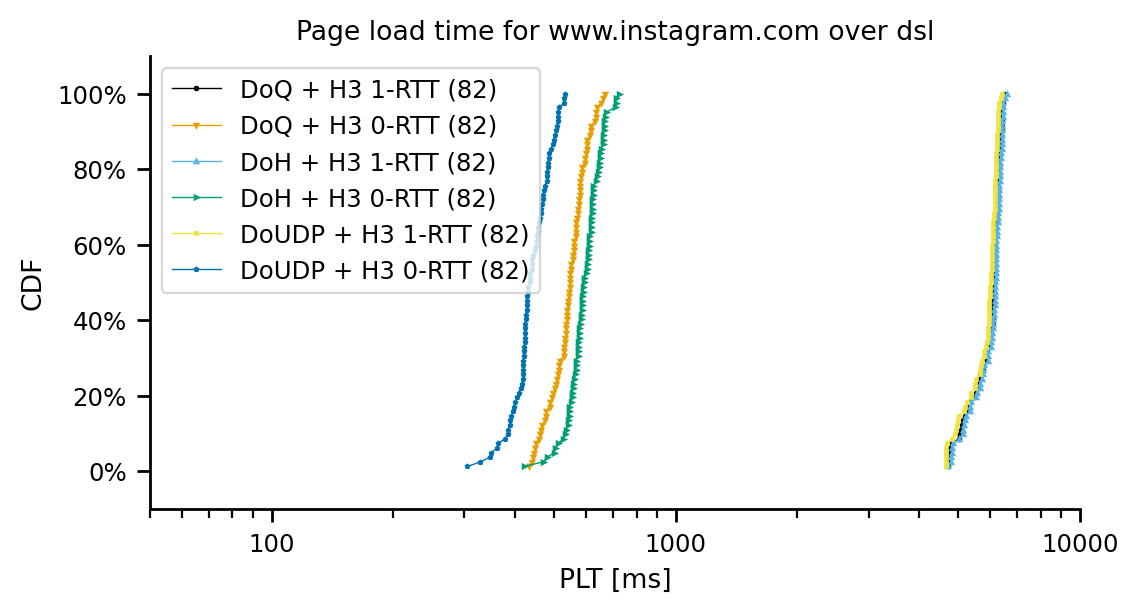

cable
count     84.000000
mean     266.274573
std       44.065380
min      171.513814
10%      210.905884
20%      230.664279
25%      234.036119
30%      241.719276
40%      254.618369
50%      262.137048
60%      275.899144
70%      289.472791
75%      297.280196
80%      303.004731
90%      324.661355
100%     378.608142
max      378.608142
Name: full_plt, dtype: float64
count     84.000000
mean     170.415049
std       34.219809
min       95.191698
10%      127.259484
20%      139.826682
25%      147.909657
30%      151.672601
40%      161.623772
50%      167.040851
60%      173.598063
70%      187.053847
75%      201.157952
80%      206.035219
90%      214.850103
100%     240.670170
max      240.670170
Name: full_plt, dtype: float64
count     84.000000
mean     302.483222
std       51.758069
min      205.169323
10%      235.878236
20%      253.766879
25%      265.410431
30%      276.431811
40%      285.612272
50%      293.040601
60%      318.425864
70%      326.052379
75%      333

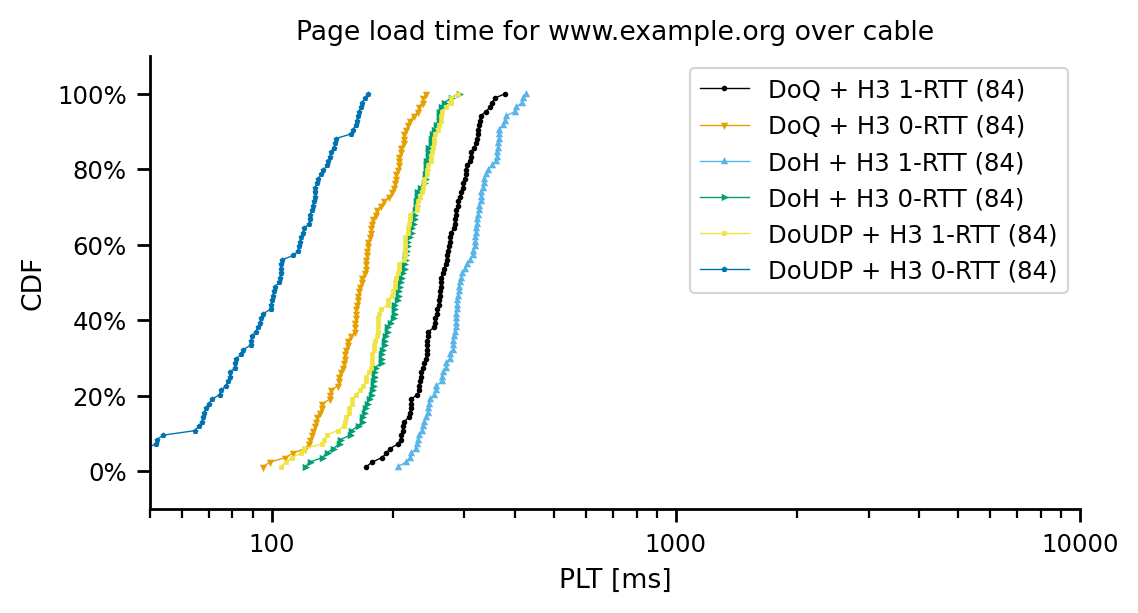

count     83.000000
mean     638.763405
std       51.372399
min      544.630176
10%      570.687982
20%      589.013512
25%      598.784845
30%      604.543727
40%      626.034039
50%      637.698237
60%      655.983615
70%      667.386102
75%      671.783810
80%      684.773074
90%      706.665584
100%     748.808834
max      748.808834
Name: full_plt, dtype: float64
count     83.000000
mean     211.806778
std       34.384304
min      130.377218
10%      171.456378
20%      183.962406
25%      192.210909
30%      195.068618
40%      202.917470
50%      209.179411
60%      217.610375
70%      226.649235
75%      230.075934
80%      242.478134
90%      254.026147
100%     292.460025
max      292.460025
Name: full_plt, dtype: float64
count     83.000000
mean     676.325842
std       52.640428
min      570.486714
10%      605.827396
20%      632.667760
25%      639.047058
30%      649.586213
40%      664.918799
50%      674.124969
60%      689.046632
70%      701.691978
75%      712.42199

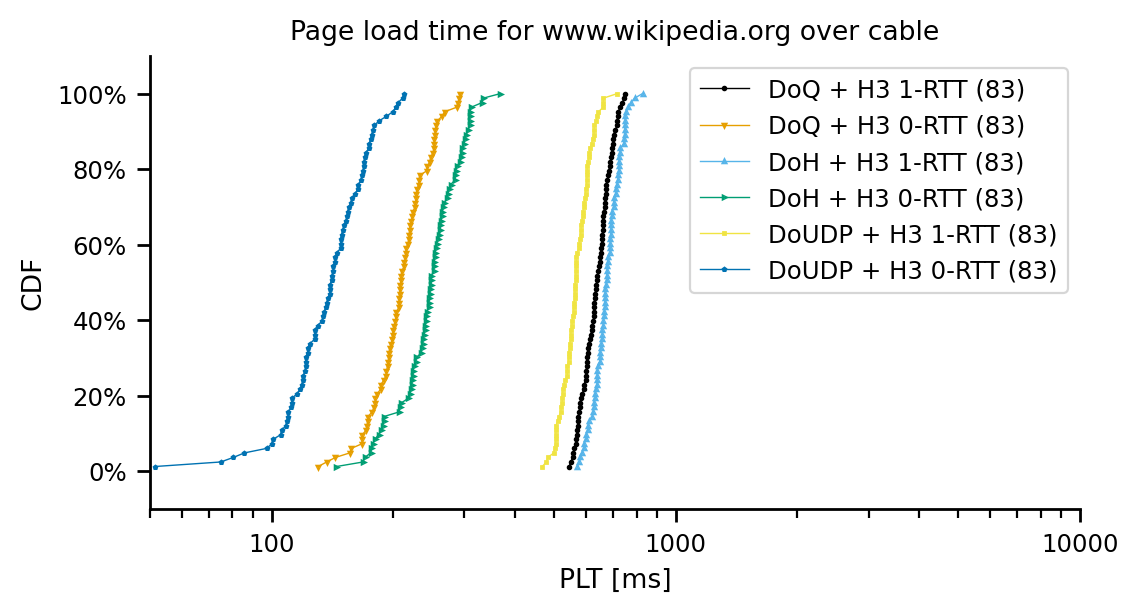

count      82.000000
mean     4361.665942
std       620.928792
min      2116.133494
10%      3467.206854
20%      3885.663722
25%      4301.553191
30%      4406.509587
40%      4516.196140
50%      4594.818170
60%      4658.288129
70%      4715.512308
75%      4740.885274
80%      4776.374731
90%      4847.888519
100%     4970.677028
max      4970.677028
Name: full_plt, dtype: float64
count     82.000000
mean     393.034234
std       40.293197
min      302.227906
10%      340.447226
20%      354.449874
25%      359.400267
30%      365.074040
40%      375.482422
50%      402.484766
60%      410.547542
70%      419.989696
75%      423.553640
80%      427.797162
90%      440.595242
100%     495.649044
max      495.649044
Name: full_plt, dtype: float64
count      82.000000
mean     4397.333590
std       614.062342
min      2082.848973
10%      3518.260972
20%      3895.771135
25%      4348.873209
30%      4454.296374
40%      4555.033466
50%      4620.494336
60%      4688.748969
70%      4

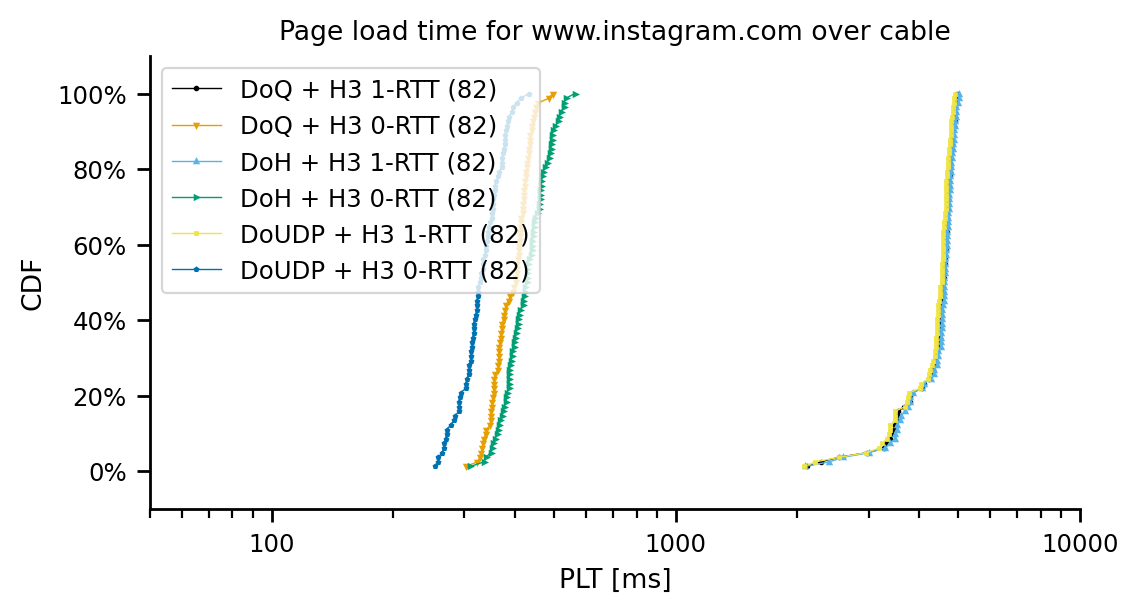

fiber
count     84.000000
mean     168.085931
std       18.464786
min      129.225521
10%      146.288355
20%      153.126157
25%      155.348975
30%      157.115060
40%      161.479642
50%      166.061045
60%      171.991042
70%      177.126738
75%      178.955844
80%      182.182502
90%      194.291495
100%     214.302942
max      214.302942
Name: full_plt, dtype: float64
count     84.000000
mean      99.816884
std       12.052130
min       75.135121
10%       86.248516
20%       88.951585
25%       89.892102
30%       92.090906
40%       96.111368
50%       99.326589
60%      102.837533
70%      105.043319
75%      106.016275
80%      109.708998
90%      116.350265
100%     136.470560
max      136.470560
Name: full_plt, dtype: float64
count     84.000000
mean     185.309490
std       18.012728
min      133.672388
10%      164.434391
20%      172.211627
25%      173.390689
30%      175.973036
40%      179.627172
50%      182.874266
60%      184.848464
70%      191.238376
75%      192

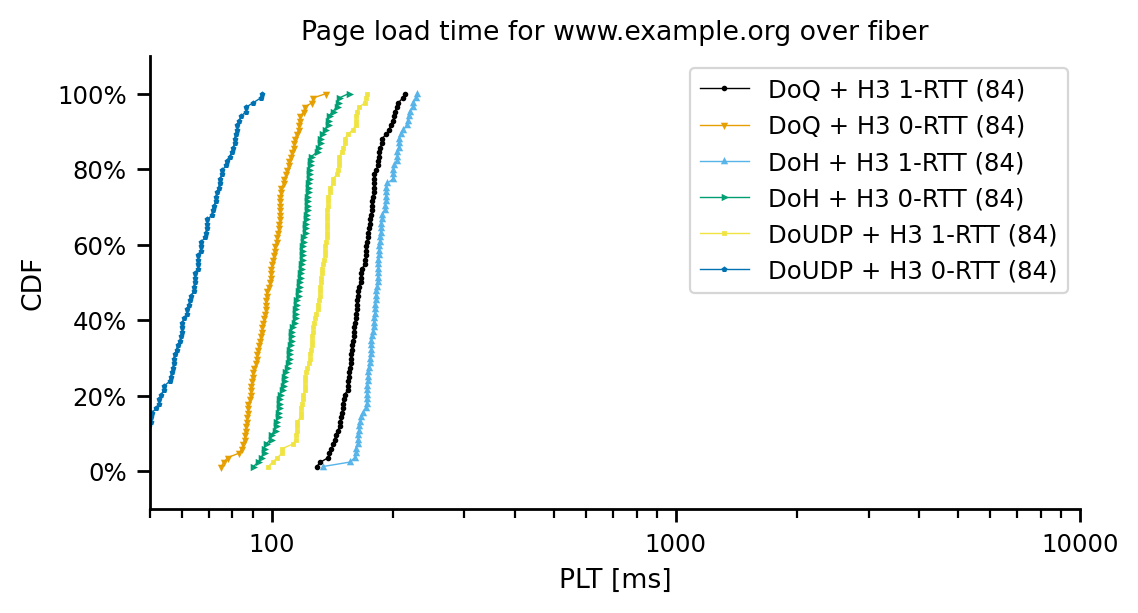

count     83.000000
mean     529.127781
std       36.361216
min      462.383814
10%      489.837791
20%      500.210885
25%      504.117205
30%      507.328692
40%      512.324874
50%      521.274275
60%      526.537262
70%      546.123233
75%      555.722637
80%      563.988142
90%      576.620884
100%     659.874789
max      659.874789
Name: full_plt, dtype: float64
count     83.000000
mean     135.926576
std       18.313576
min       98.732127
10%      114.860210
20%      120.875278
25%      124.641341
30%      127.471114
40%      130.726062
50%      133.938146
60%      137.097145
70%      142.345296
75%      143.498633
80%      146.393403
90%      162.327085
100%     198.117389
max      198.117389
Name: full_plt, dtype: float64
count     83.000000
mean     546.074381
std       35.351046
min      490.366743
10%      504.681351
20%      514.913124
25%      518.332319
30%      521.677998
40%      530.089244
50%      538.139380
60%      549.257634
70%      569.161346
75%      575.65551

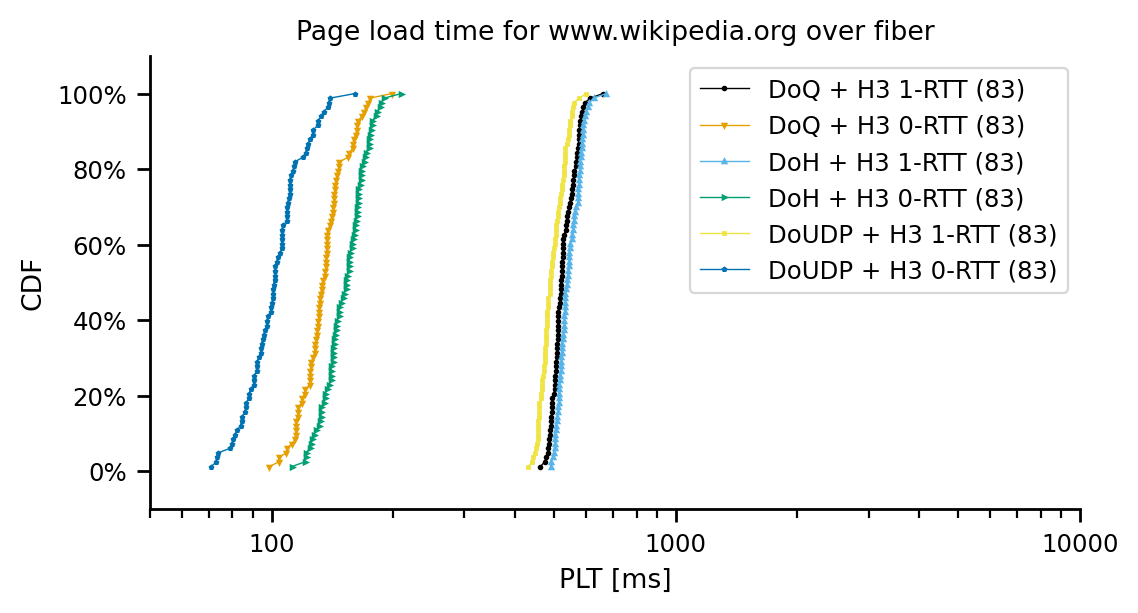

count      82.000000
mean     2144.716013
std       242.280217
min      1135.388188
10%      1851.715817
20%      2002.037922
25%      2073.853175
30%      2168.929301
40%      2216.050812
50%      2233.762572
60%      2259.387231
70%      2268.970082
75%      2281.296182
80%      2298.548634
90%      2329.830952
100%     2382.605101
max      2382.605101
Name: full_plt, dtype: float64
count     82.000000
mean     311.729427
std       24.809303
min      264.056338
10%      280.212152
20%      289.996314
25%      293.159435
30%      297.848684
40%      302.551525
50%      309.994826
60%      315.562257
70%      323.722641
75%      327.247595
80%      333.741691
90%      342.507423
100%     389.445605
max      389.445605
Name: full_plt, dtype: float64
count      82.000000
mean     2162.896812
std       243.499907
min      1127.410617
10%      1859.994473
20%      2021.204894
25%      2085.100632
30%      2189.858443
40%      2223.755675
50%      2261.283335
60%      2276.967580
70%      2

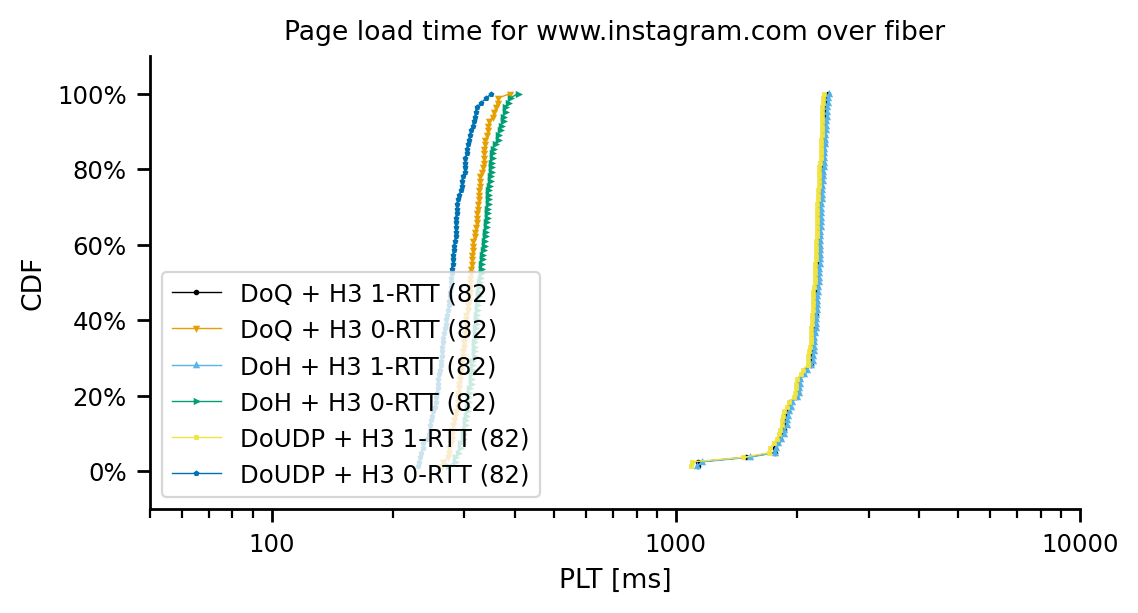

4g
count     83.000000
mean     520.656103
std       43.295647
min      411.993779
10%      466.845037
20%      487.638102
25%      491.543188
30%      495.657193
40%      506.254345
50%      518.016280
60%      530.368226
70%      542.558060
75%      552.808652
80%      557.766971
90%      575.027141
100%     633.271283
max      633.271283
Name: full_plt, dtype: float64
count     83.000000
mean     366.458512
std       36.507864
min      282.019382
10%      317.836212
20%      335.234478
25%      342.355211
30%      346.359235
40%      353.365570
50%      366.068801
60%      380.831165
70%      390.122694
75%      394.554464
80%      400.502833
90%      413.207281
100%     439.248728
max      439.248728
Name: full_plt, dtype: float64
count     83.000000
mean     620.160676
std       44.024510
min      534.520705
10%      559.538978
20%      580.865954
25%      590.565425
30%      597.709844
40%      611.050138
50%      616.137194
60%      628.458893
70%      647.873452
75%      652.31

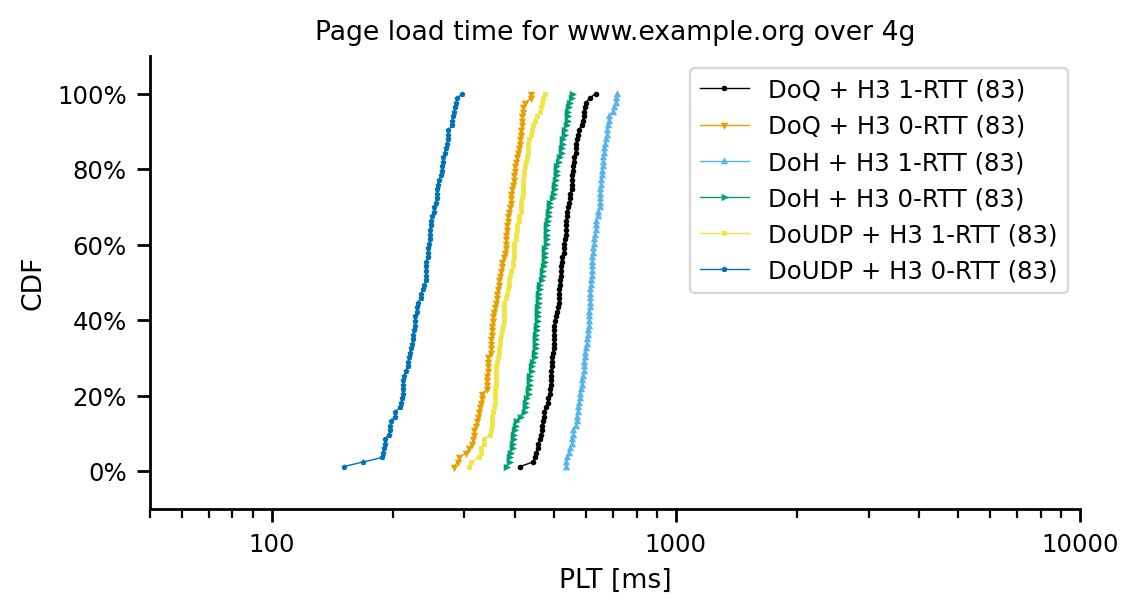

count      83.000000
mean      972.685153
std        65.637815
min       810.450985
10%       897.597807
20%       928.638791
25%       934.583803
30%       941.617484
40%       952.387196
50%       969.734439
60%       979.811784
70%       996.182195
75%      1009.674298
80%      1022.589021
90%      1051.141790
100%     1147.677463
max      1147.677463
Name: full_plt, dtype: float64
count     83.000000
mean     402.774310
std       33.917017
min      341.603324
10%      359.425002
20%      373.443144
25%      378.217081
30%      380.740833
40%      389.960724
50%      398.050985
60%      416.589347
70%      422.967199
75%      426.116501
80%      430.432467
90%      450.700071
100%     493.833335
max      493.833335
Name: full_plt, dtype: float64
count      83.000000
mean     1078.228330
std        67.535526
min       903.083229
10%      1002.138431
20%      1014.906778
25%      1022.698659
30%      1035.928366
40%      1060.442869
50%      1082.067073
60%      1091.728262
70%      1

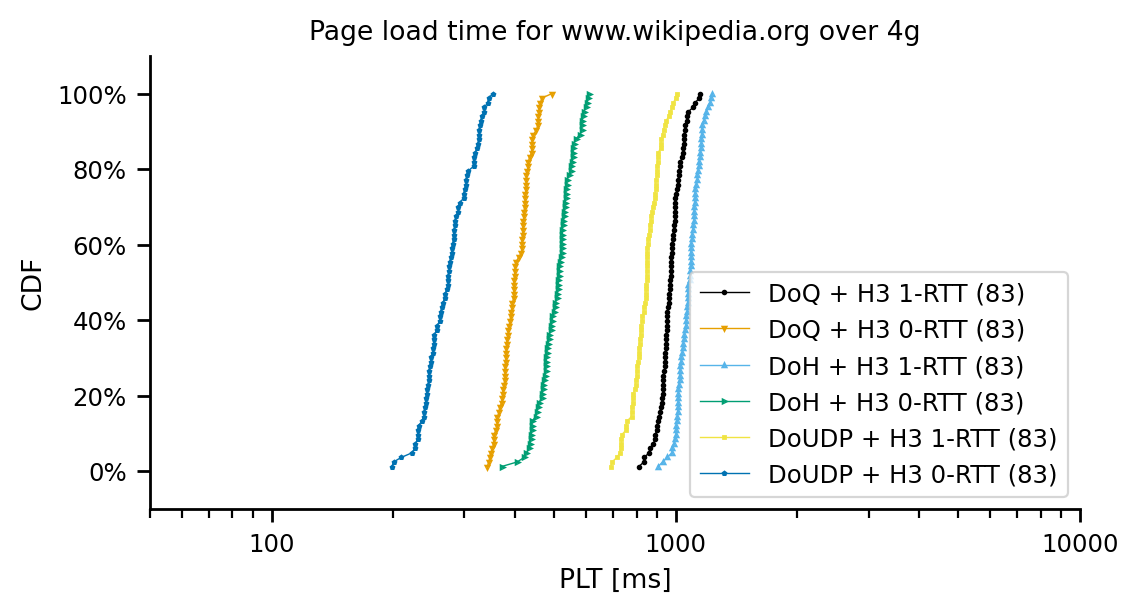

count      82.000000
mean     7784.149570
std      1418.672616
min      2134.953809
10%      6376.904580
20%      6517.641019
25%      8170.561040
30%      8268.080405
40%      8316.381875
50%      8378.431630
60%      8416.939870
70%      8462.887211
75%      8512.410404
80%      8575.887598
90%      8665.273792
100%     8809.174425
max      8809.174425
Name: full_plt, dtype: float64
count     82.000000
mean     653.567863
std       46.349235
min      538.546737
10%      590.149413
20%      609.664570
25%      621.034681
30%      630.212795
40%      642.622604
50%      655.309550
60%      667.951481
70%      679.101245
75%      685.609485
80%      688.465554
90%      712.407175
100%     765.335782
max      765.335782
Name: full_plt, dtype: float64
count      82.000000
mean     7886.224020
std      1419.465531
min      2247.232595
10%      6460.397325
20%      6626.424887
25%      8270.921684
30%      8354.920871
40%      8427.643837
50%      8460.825829
60%      8534.303490
70%      8

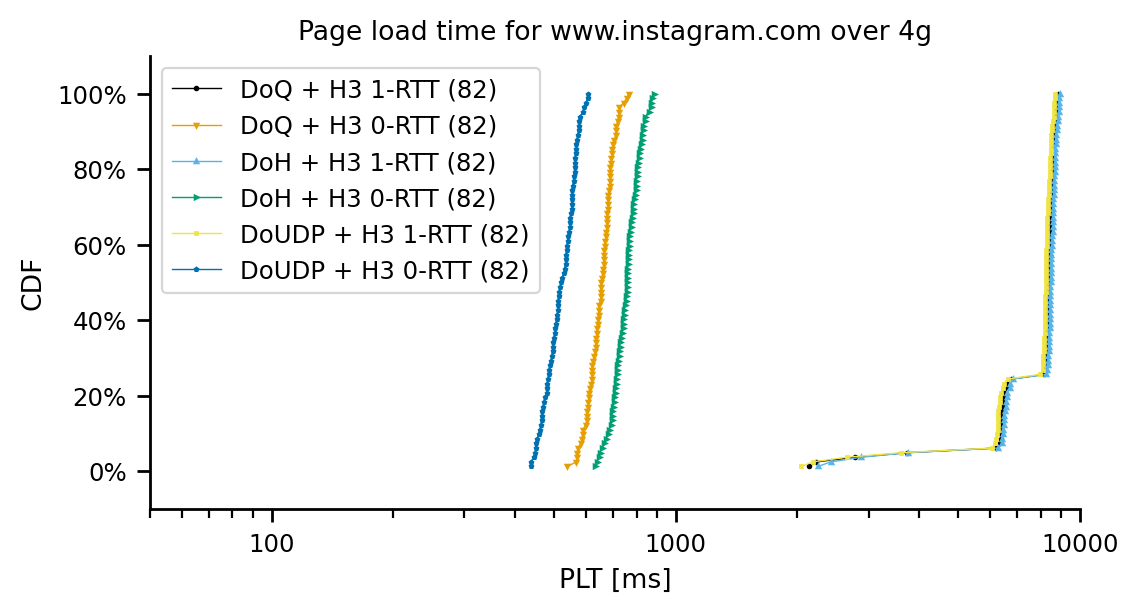

4g-medium
count     83.000000
mean     594.371098
std       48.190041
min      477.712399
10%      535.836958
20%      548.050584
25%      553.455574
30%      565.211875
40%      578.232739
50%      599.843420
60%      608.648318
70%      615.111185
75%      626.251389
80%      637.252145
90%      659.363030
100%     718.055355
max      718.055355
Name: full_plt, dtype: float64
count     83.000000
mean     412.803628
std       42.736984
min      309.699751
10%      350.642335
20%      372.114414
25%      386.253639
30%      395.465187
40%      405.848839
50%      420.731413
60%      426.508708
70%      434.589126
75%      439.865077
80%      448.717044
90%      463.521912
100%     513.255355
max      513.255355
Name: full_plt, dtype: float64
count     83.000000
mean     714.422839
std       62.345765
min      580.053225
10%      634.234621
20%      655.522529
25%      664.383971
30%      676.875309
40%      700.417285
50%      712.128469
60%      728.060056
70%      750.261608
75%     

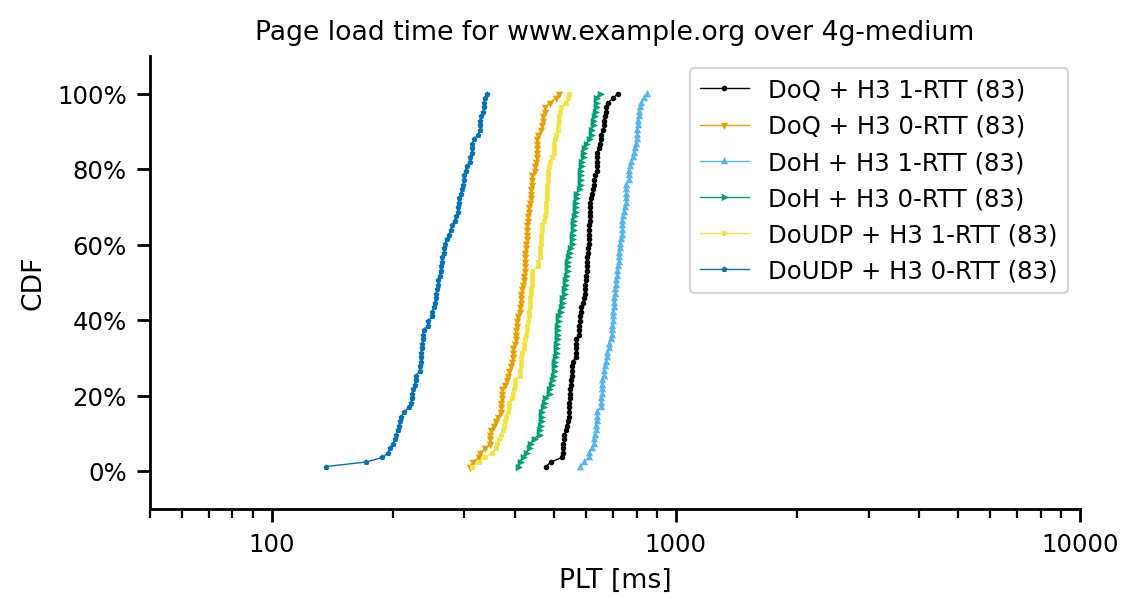

count      82.000000
mean     1065.536190
std        76.336423
min       904.876161
10%       966.640656
20%      1000.066617
25%      1007.360082
30%      1020.152315
40%      1034.665434
50%      1061.017855
60%      1091.603106
70%      1107.849192
75%      1113.218142
80%      1136.016285
90%      1170.282758
100%     1253.871072
max      1253.871072
Name: full_plt, dtype: float64
count     82.000000
mean     457.513019
std       44.231741
min      350.818504
10%      398.818737
20%      420.290245
25%      428.200928
30%      433.620151
40%      446.903106
50%      456.954835
60%      468.527505
70%      485.117275
75%      489.933763
80%      494.123809
90%      504.199340
100%     566.371072
max      566.371072
Name: full_plt, dtype: float64
count      82.000000
mean     1180.841636
std        87.576651
min       984.742139
10%      1086.651973
20%      1102.275204
25%      1118.488369
30%      1137.056604
40%      1156.776879
50%      1173.175714
60%      1205.012058
70%      1

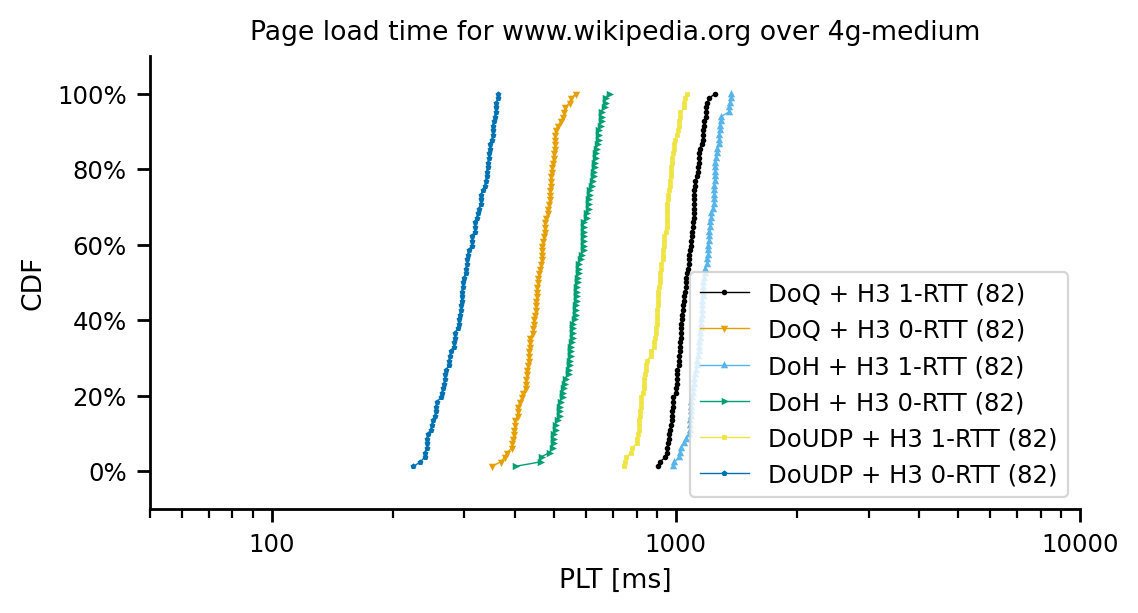

count       82.000000
mean      8678.210860
std       2171.956846
min       2843.474228
10%       3585.620939
20%       7549.542122
25%       8076.111317
30%       9563.813627
40%       9631.935617
50%       9708.240568
60%       9770.643836
70%       9823.685692
75%       9844.138988
80%       9863.322716
90%       9961.580246
100%     10390.158773
max      10390.158773
Name: full_plt, dtype: float64
count     82.000000
mean     739.285250
std       49.415503
min      616.996944
10%      673.957374
20%      695.875768
25%      709.540298
30%      715.890061
40%      730.277413
50%      740.749749
60%      754.182383
70%      766.111800
75%      777.217870
80%      783.060010
90%      799.743852
100%     835.330382
max      835.330382
Name: full_plt, dtype: float64
count       82.000000
mean      8781.789630
std       2174.026082
min       3001.656380
10%       3634.712586
20%       7679.313326
25%       8240.158012
30%       9589.987987
40%       9709.424542
50%       9830.033900
60% 

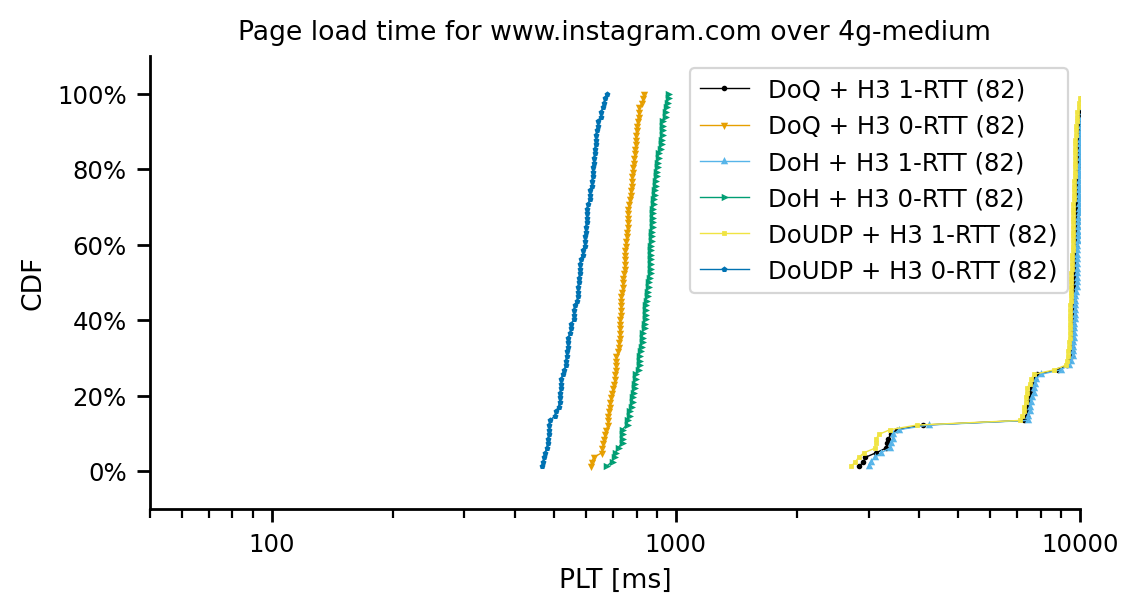

In [30]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_plt', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_plt']) == 0:
                    continue
                print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_plt'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('Page load time for '+website+' over '+access_technology)

        ax.set_xlabel('PLT [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

dsl
count     84.000000
mean     382.712100
std       50.459511
min      204.821549
10%      321.209186
20%      340.506049
25%      345.316856
30%      353.091999
40%      375.828885
50%      392.662063
60%      399.616126
70%      406.318165
75%      413.191699
80%      422.538871
90%      445.260825
100%     498.049233
max      498.049233
Name: full_fcp, dtype: float64
count     84.000000
mean     271.239481
std       42.134176
min      179.019853
10%      210.936088
20%      237.552122
25%      242.176621
30%      248.714254
40%      261.264786
50%      266.268805
60%      281.600176
70%      298.256682
75%      309.711624
80%      314.566346
90%      322.439272
100%     349.770880
max      349.770880
Name: full_fcp, dtype: float64
count     84.000000
mean     432.016135
std       61.189240
min      278.117289
10%      347.742290
20%      382.516860
25%      393.204329
30%      398.550834
40%      411.669618
50%      435.079893
60%      450.742347
70%      467.690688
75%      476.0

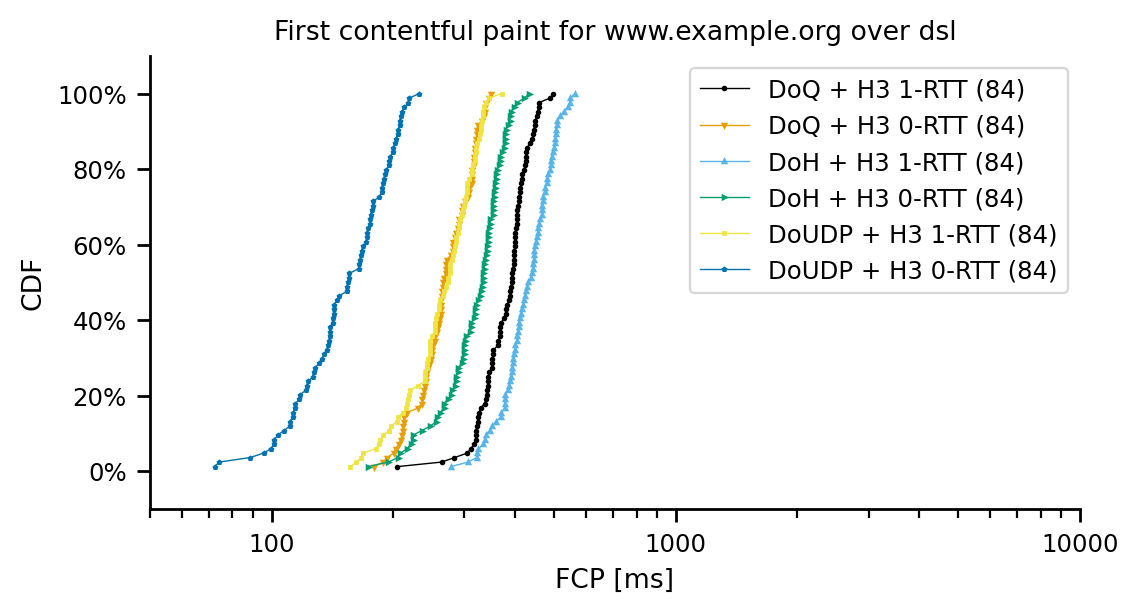

count     83.000000
mean     604.536691
std      124.267960
min      400.621568
10%      459.658867
20%      484.845285
25%      496.485739
30%      511.106383
40%      534.413205
50%      587.271063
60%      644.146976
70%      692.660099
75%      728.413006
80%      748.840528
90%      780.061494
100%     843.492317
max      843.492317
Name: full_fcp, dtype: float64
count     83.000000
mean     270.166812
std       41.138744
min      179.127513
10%      216.488929
20%      241.711737
25%      245.722866
30%      248.559252
40%      255.444255
50%      268.671796
60%      278.634549
70%      293.218813
75%      295.963006
80%      301.246677
90%      325.579842
100%     363.667294
max      363.667294
Name: full_fcp, dtype: float64
count     83.000000
mean     654.554443
std      129.023927
min      415.514984
10%      495.019104
20%      533.612820
25%      545.367477
30%      564.014256
40%      587.059007
50%      644.020506
60%      699.207817
70%      754.890620
75%      781.61680

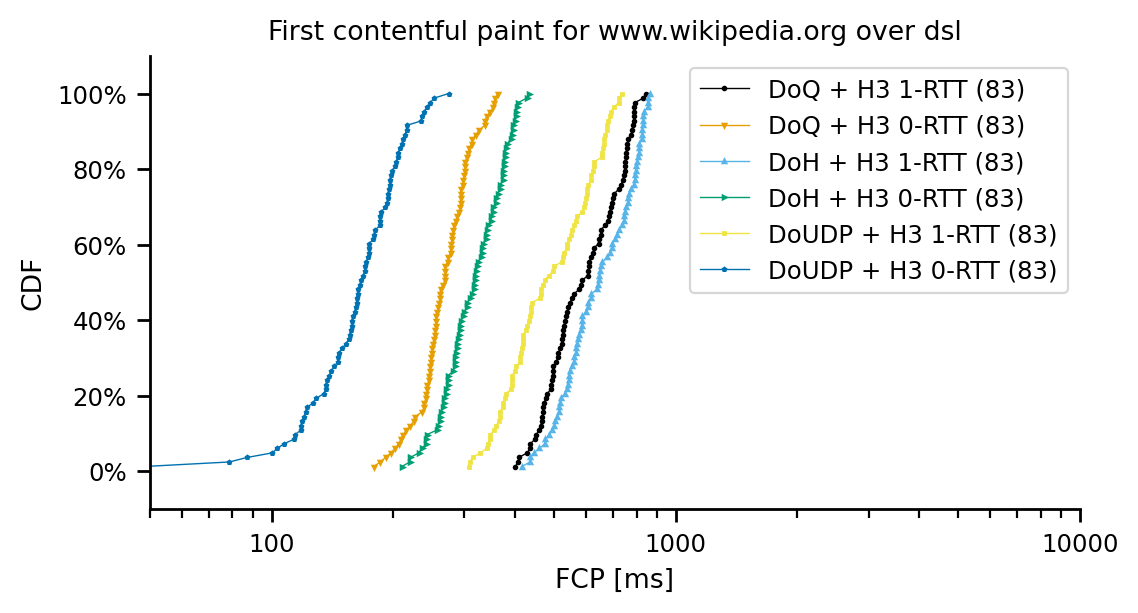

count     82.000000
mean     395.733448
std       52.955182
min      272.496654
10%      328.903494
20%      355.654860
25%      358.623485
30%      364.796853
40%      377.016307
50%      389.636619
60%      405.859650
70%      419.578406
75%      434.065318
80%      447.139848
90%      470.509218
100%     533.818157
max      533.818157
Name: full_fcp, dtype: float64
count     82.000000
mean     292.910277
std       50.402952
min      176.196654
10%      225.211639
20%      250.620759
25%      258.756024
30%      265.668479
40%      285.385518
50%      297.585085
60%      305.022903
70%      317.982905
75%      331.539853
80%      335.429003
90%      350.560669
100%     401.010590
max      401.010590
Name: full_fcp, dtype: float64
count     82.000000
mean     445.622204
std       58.743623
min      313.436979
10%      382.175478
20%      395.347479
25%      401.229944
30%      415.954598
40%      434.322339
50%      442.986134
60%      449.013691
70%      479.790795
75%      491.38108

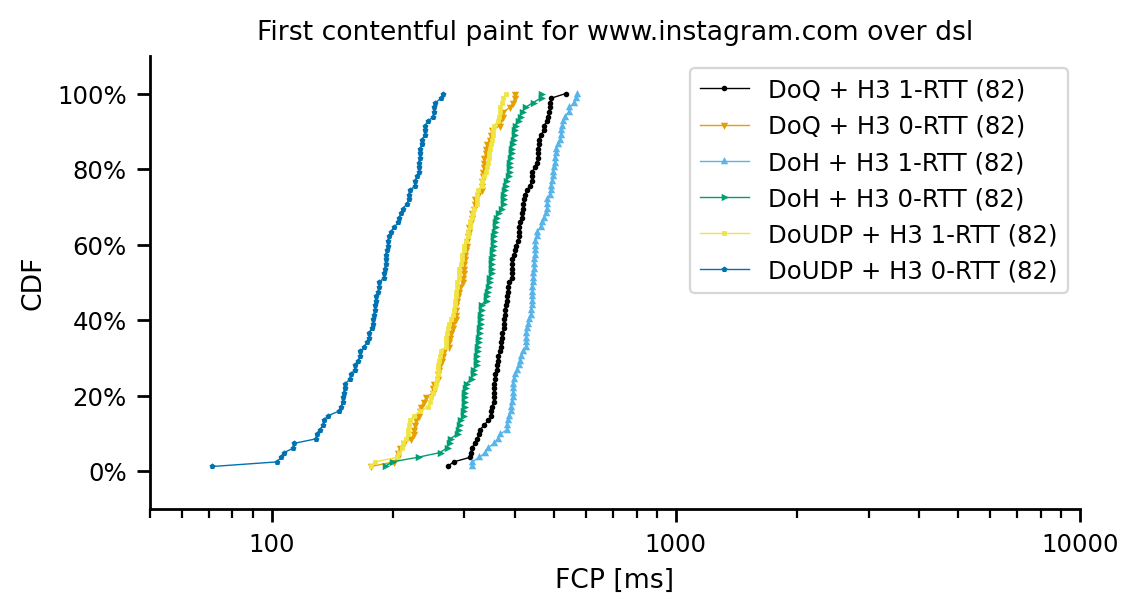

cable
count     84.000000
mean     270.935287
std       40.491596
min      188.513814
10%      221.931428
20%      235.139811
25%      239.429758
30%      247.066533
40%      255.611024
50%      268.254257
60%      279.843202
70%      291.493889
75%      299.491961
80%      306.649766
90%      325.619054
100%     375.608142
max      375.608142
Name: full_fcp, dtype: float64
count     84.000000
mean     181.753144
std       34.189491
min      104.491698
10%      138.578123
20%      153.113259
25%      159.718065
30%      165.482025
40%      172.565096
50%      179.864754
60%      186.941843
70%      196.367266
75%      212.662916
80%      216.975219
90%      226.082634
100%     252.092259
max      252.092259
Name: full_fcp, dtype: float64
count     84.000000
mean     307.143937
std       48.982243
min      217.081002
10%      240.745332
20%      268.068235
25%      275.022982
30%      280.738018
40%      287.623336
50%      305.256438
60%      317.811852
70%      329.205947
75%      337

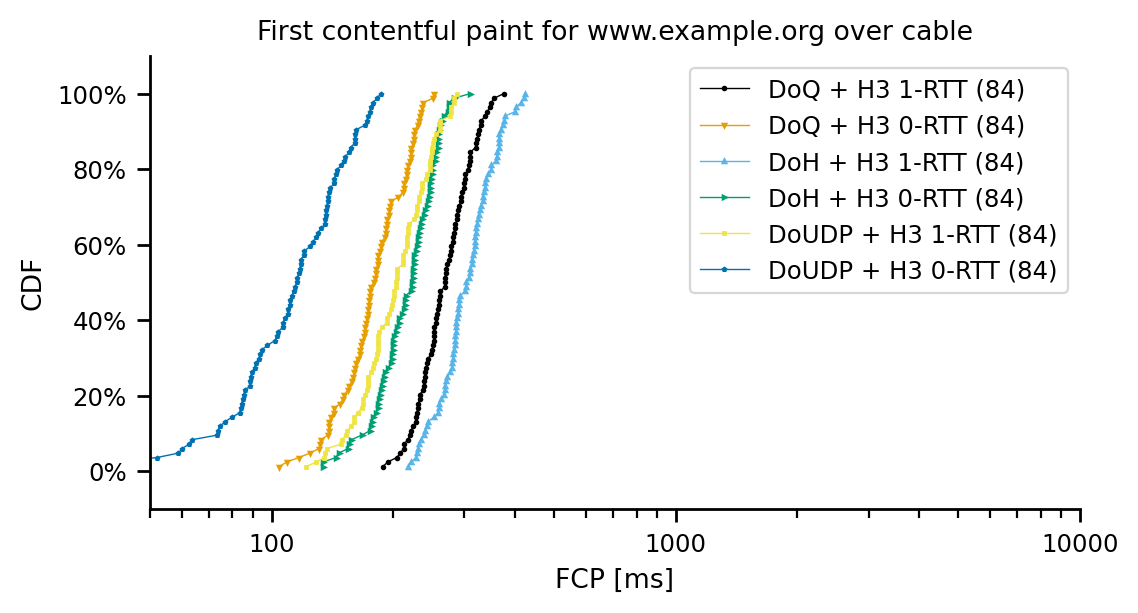

count     83.000000
mean     515.454971
std      114.661422
min      251.330176
10%      361.080484
20%      377.445828
25%      399.603113
30%      426.966633
40%      486.928581
50%      544.843193
60%      570.237639
70%      606.317875
75%      621.910763
80%      632.763467
90%      646.053698
100%     686.098960
max      686.098960
Name: full_fcp, dtype: float64
count     83.000000
mean     190.226055
std       33.564912
min      110.477218
10%      150.133322
20%      160.415277
25%      167.293087
30%      175.192367
40%      183.596432
50%      188.678243
60%      193.661679
70%      205.977476
75%      213.575861
80%      220.862869
90%      238.158553
100%     277.552615
max      277.552615
Name: full_fcp, dtype: float64
count     83.000000
mean     553.017408
std      114.932078
min      344.955366
10%      384.090968
20%      418.987432
25%      444.618463
30%      469.985099
40%      543.203240
50%      595.363366
60%      616.966522
70%      639.625133
75%      642.17217

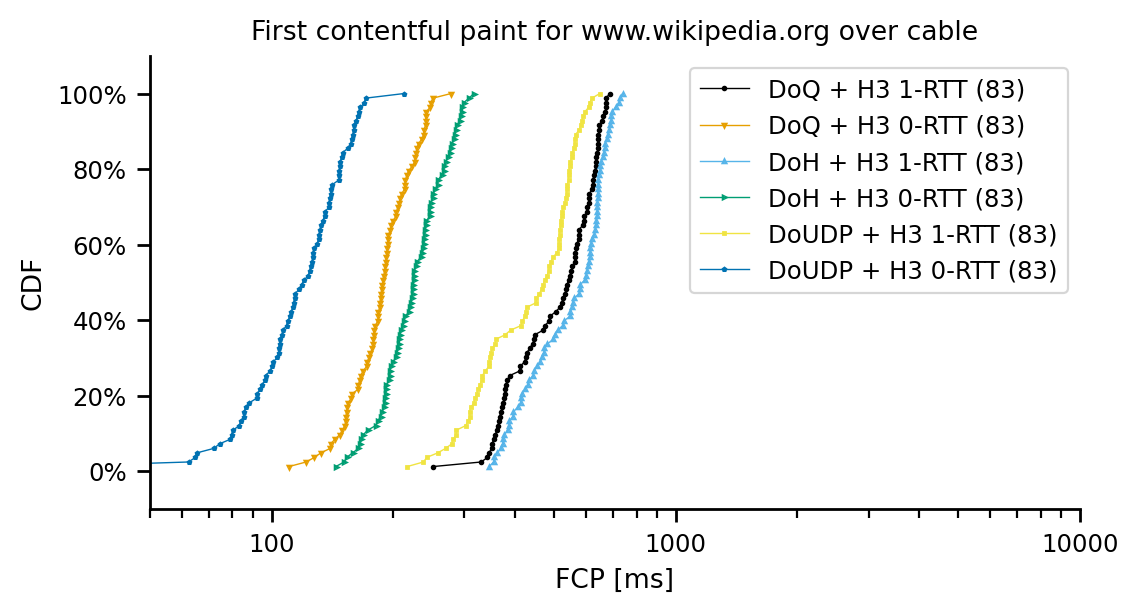

count     82.000000
mean     286.392771
std       40.875875
min      188.014645
10%      234.705496
20%      254.278106
25%      257.619467
30%      263.437289
40%      275.112451
50%      284.932069
60%      295.752327
70%      306.728503
75%      314.522517
80%      317.418956
90%      340.355266
100%     376.047655
max      376.047655
Name: full_fcp, dtype: float64
count     82.000000
mean     217.157405
std       38.112157
min      133.127906
10%      167.299232
20%      181.893507
25%      189.595833
30%      195.653271
40%      205.055486
50%      218.960068
60%      225.676160
70%      239.492246
75%      247.761069
80%      251.279466
90%      262.485484
100%     312.332101
max      312.332101
Name: full_fcp, dtype: float64
count     82.000000
mean     322.060419
std       52.364067
min      159.101401
10%      268.981575
20%      287.536032
25%      294.844904
30%      297.656983
40%      308.841039
50%      316.853978
60%      327.460591
70%      341.845421
75%      346.66074

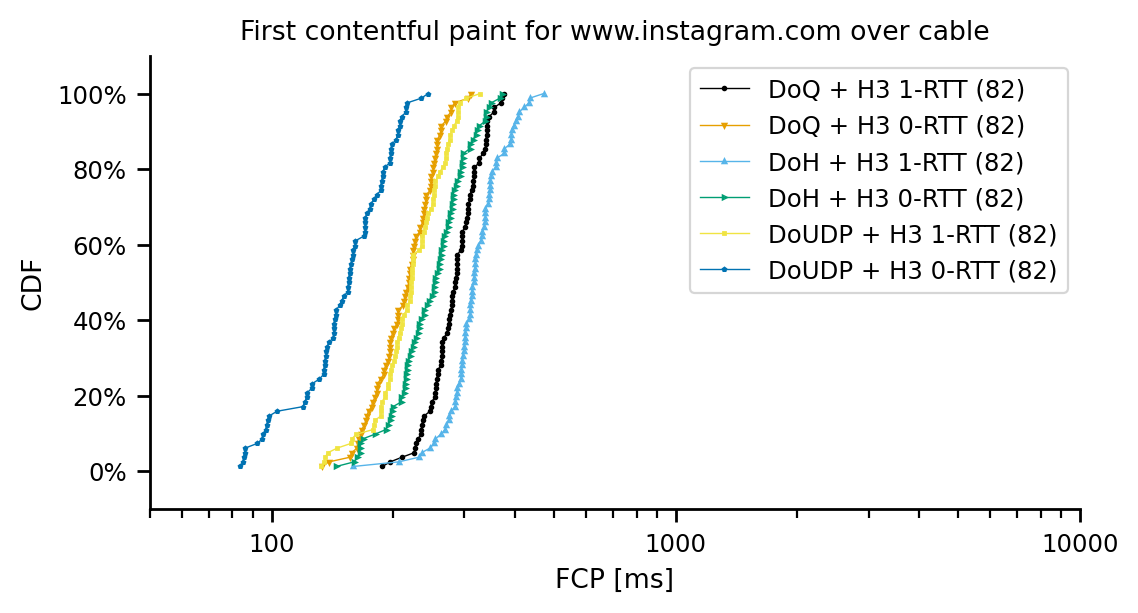

fiber
count     84.000000
mean     182.131169
std       14.720854
min      147.833966
10%      164.480019
20%      171.142610
25%      173.033383
30%      175.047870
40%      177.398375
50%      181.409016
60%      185.478980
70%      190.799327
75%      192.685658
80%      194.266952
90%      199.447902
100%     222.691533
max      222.691533
Name: full_fcp, dtype: float64
count     84.000000
mean     110.789503
std       11.549477
min       83.919866
10%       96.614042
20%      100.393359
25%      102.880203
30%      104.563702
40%      107.259310
50%      110.213746
60%      113.763975
70%      117.623573
75%      119.274669
80%      121.081756
90%      125.597023
100%     145.670560
max      145.670560
Name: full_fcp, dtype: float64
count     84.000000
mean     199.354728
std       13.922424
min      149.372388
10%      182.315647
20%      188.996448
25%      191.001798
30%      192.728062
40%      197.279519
50%      199.855012
60%      202.813814
70%      204.786435
75%      206

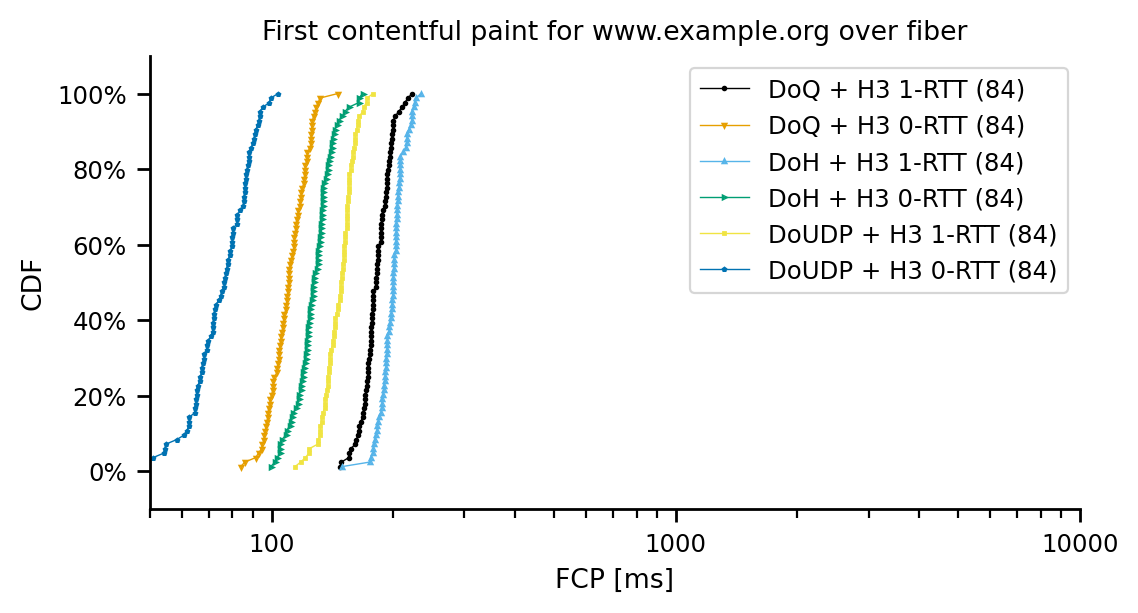

count     83.000000
mean     360.353082
std      109.998580
min      236.059377
10%      266.870778
20%      278.226465
25%      284.989261
30%      289.199021
40%      297.078187
50%      302.546883
60%      315.172227
70%      376.180634
75%      481.321000
80%      495.995338
90%      545.642596
100%     620.674789
max      620.674789
Name: full_fcp, dtype: float64
count     83.000000
mean     116.362721
std       21.882441
min       83.141546
10%       94.189163
20%       98.437728
25%      101.746184
30%      103.557014
40%      112.025527
50%      115.799404
60%      117.767966
70%      120.960421
75%      124.344207
80%      127.931582
90%      139.884174
100%     237.817389
max      237.817389
Name: full_fcp, dtype: float64
count     83.000000
mean     377.299683
std      108.581657
min      245.020095
10%      292.047325
20%      297.679214
25%      300.208984
30%      303.609934
40%      309.248560
50%      321.585250
60%      334.760099
70%      394.167116
75%      492.21508

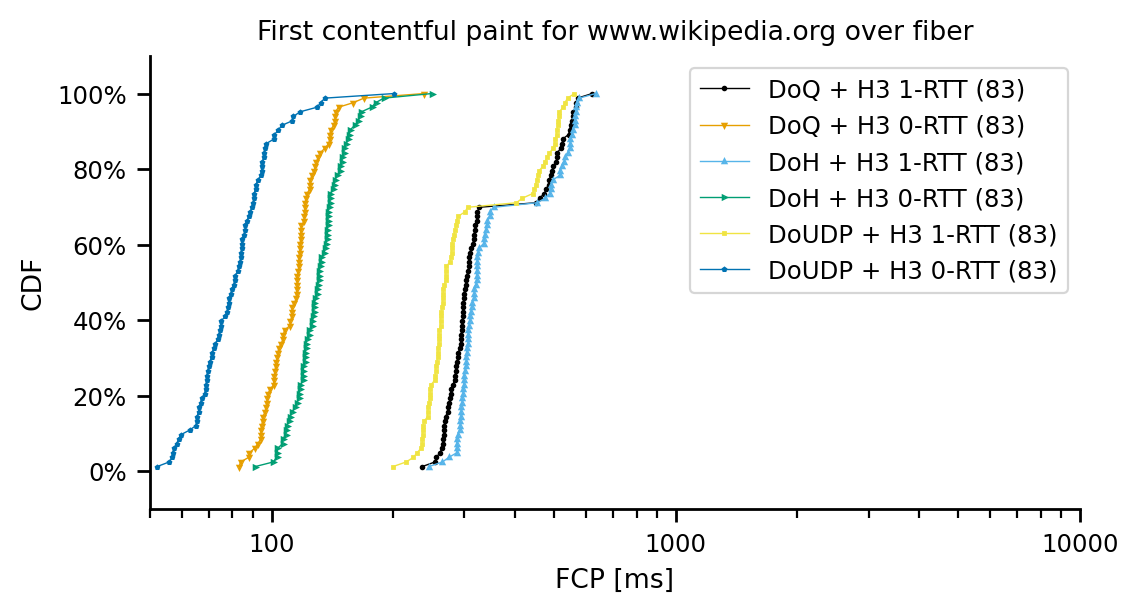

count     82.000000
mean     199.220891
std       18.910036
min      161.719067
10%      177.011816
20%      183.331114
25%      186.765946
30%      188.114183
40%      192.746870
50%      196.084418
60%      200.977236
70%      207.944456
75%      211.774621
80%      218.505839
90%      223.138985
100%     253.034377
max      253.034377
Name: full_fcp, dtype: float64
count     82.000000
mean     158.824549
std       17.321729
min      117.756338
10%      136.632963
20%      143.457787
25%      146.783811
30%      149.843211
40%      153.972945
50%      158.039693
60%      164.032888
70%      167.985834
75%      169.191329
80%      174.195814
90%      179.384924
100%     220.406226
max      220.406226
Name: full_fcp, dtype: float64
count     82.000000
mean     217.401690
std       20.697938
min      167.669571
10%      189.398054
20%      199.835933
25%      203.981732
30%      206.494140
40%      209.622408
50%      215.677367
60%      223.458870
70%      227.840234
75%      233.48276

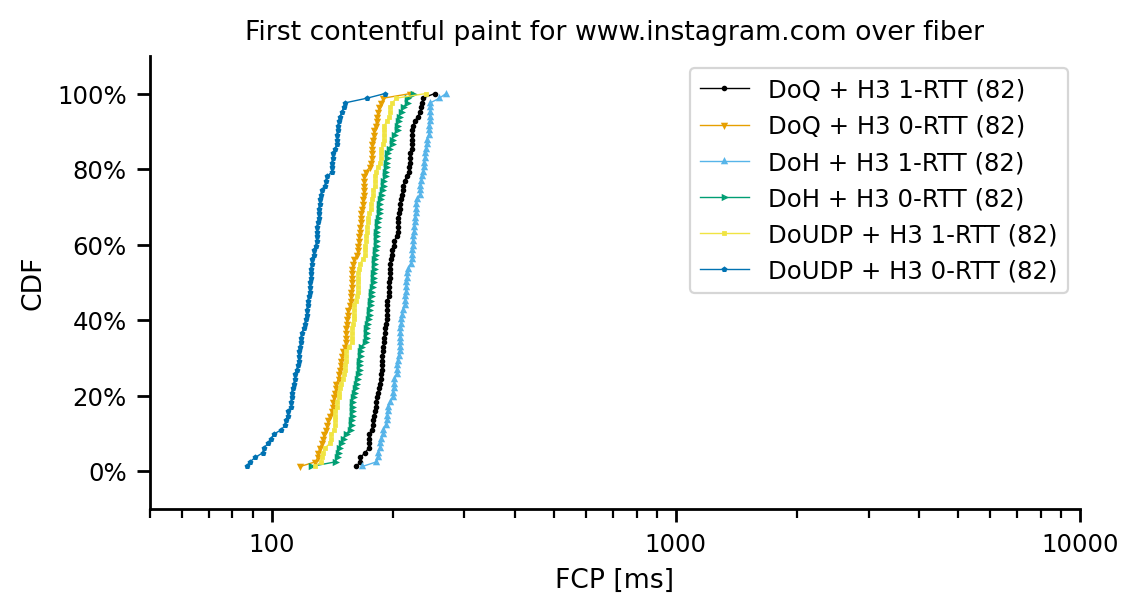

4g
count     83.000000
mean     521.186223
std       42.905822
min      411.693779
10%      468.166074
20%      487.929296
25%      490.557342
30%      496.218294
40%      505.730218
50%      518.065061
60%      530.224664
70%      544.813470
75%      552.663917
80%      557.545655
90%      573.743924
100%     632.671283
max      632.671283
Name: full_fcp, dtype: float64
count     83.000000
mean     379.168151
std       37.169961
min      293.319382
10%      327.686288
20%      350.169041
25%      356.467073
30%      359.653508
40%      364.716017
50%      379.608823
60%      393.012828
70%      402.430533
75%      410.937216
80%      413.745544
90%      425.400665
100%     452.948728
max      452.948728
Name: full_fcp, dtype: float64
count     83.000000
mean     620.690796
std       44.129775
min      532.820705
10%      564.054428
20%      581.832337
25%      593.285130
30%      598.559877
40%      610.055872
50%      618.489066
60%      631.445638
70%      648.181703
75%      652.71

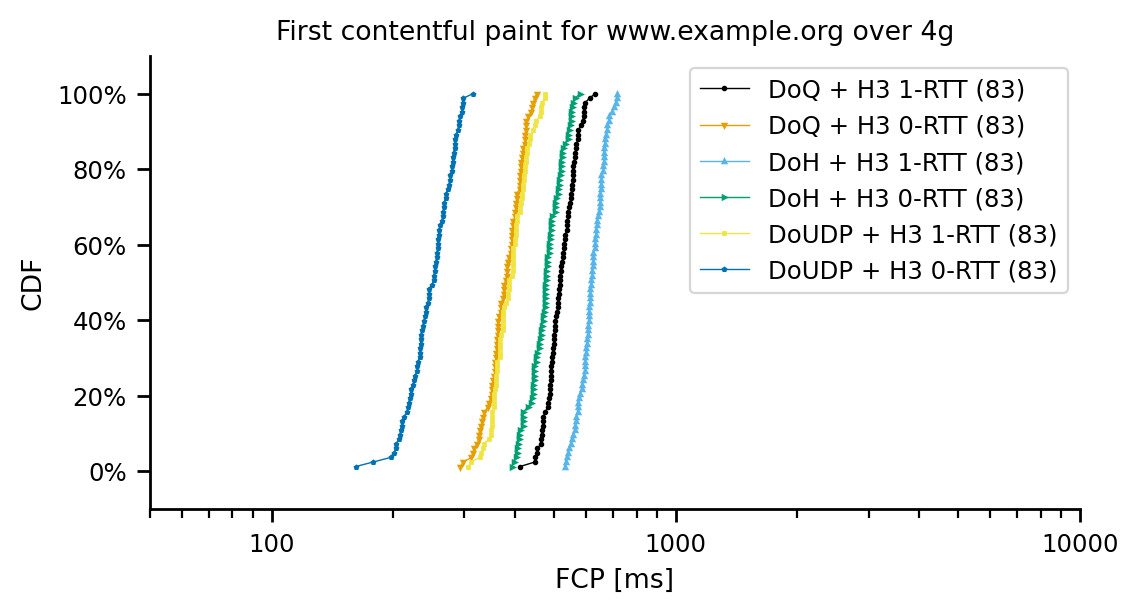

count     83.000000
mean     781.008045
std       91.389702
min      559.475260
10%      663.722669
20%      708.701447
25%      724.716479
30%      730.183777
40%      773.170926
50%      790.348410
60%      802.893554
70%      823.569023
75%      836.182172
80%      847.489559
90%      906.013355
100%     977.077463
max      977.077463
Name: full_fcp, dtype: float64
count     83.000000
mean     386.538165
std       35.128001
min      301.403247
10%      341.440519
20%      357.097269
25%      362.196355
30%      364.969604
40%      374.654050
50%      384.238383
60%      397.861932
70%      403.886091
75%      406.050888
80%      411.561829
90%      437.623211
100%     466.084275
max      466.084275
Name: full_fcp, dtype: float64
count      83.000000
mean      886.551222
std        90.561154
min       690.516956
10%       765.331673
20%       804.267190
25%       817.054972
30%       840.085796
40%       865.580256
50%       888.108000
60%       901.436212
70%       936.928221
75%   

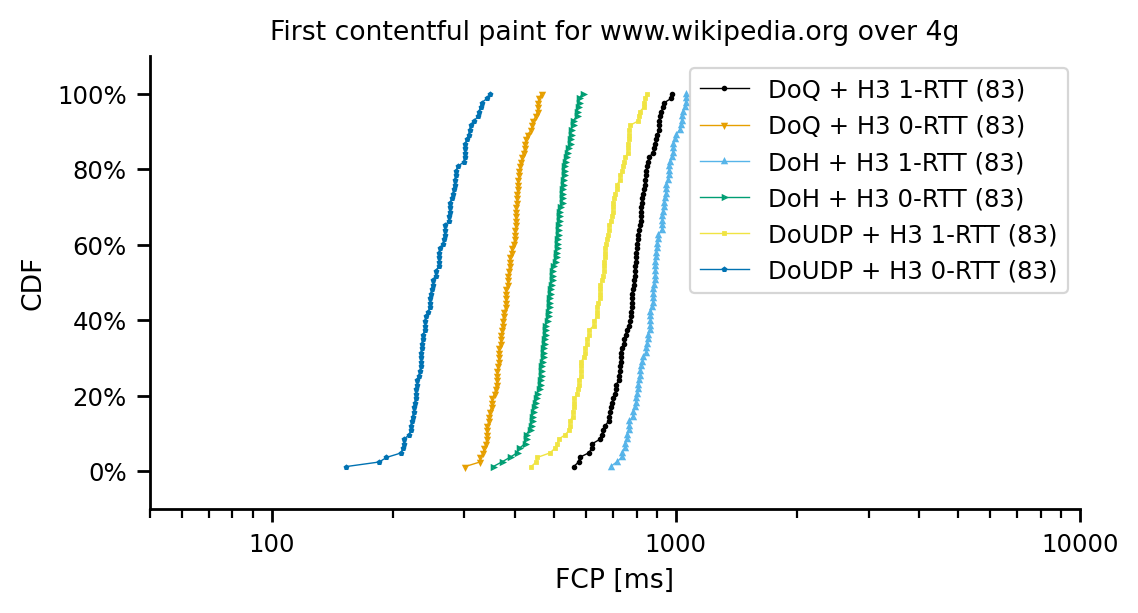

count     82.000000
mean     543.626400
std       47.483900
min      434.918961
10%      483.350800
20%      502.808729
25%      507.777352
30%      516.120780
40%      531.283092
50%      543.551914
60%      551.681398
70%      567.989536
75%      574.572672
80%      590.105550
90%      606.667661
100%     648.044743
max      648.044743
Name: full_fcp, dtype: float64
count     82.000000
mean     409.070302
std       43.539207
min      315.046737
10%      354.165808
20%      362.960069
25%      376.130875
30%      381.185521
40%      405.151316
50%      412.164460
60%      422.079640
70%      435.882018
75%      444.689411
80%      448.350035
90%      455.607118
100%     519.277395
max      519.277395
Name: full_fcp, dtype: float64
count     82.000000
mean     645.700849
std       55.321321
min      491.594631
10%      577.497905
20%      603.051828
25%      612.631593
30%      621.733297
40%      628.617292
50%      642.704169
60%      657.023438
70%      672.640590
75%      684.89239

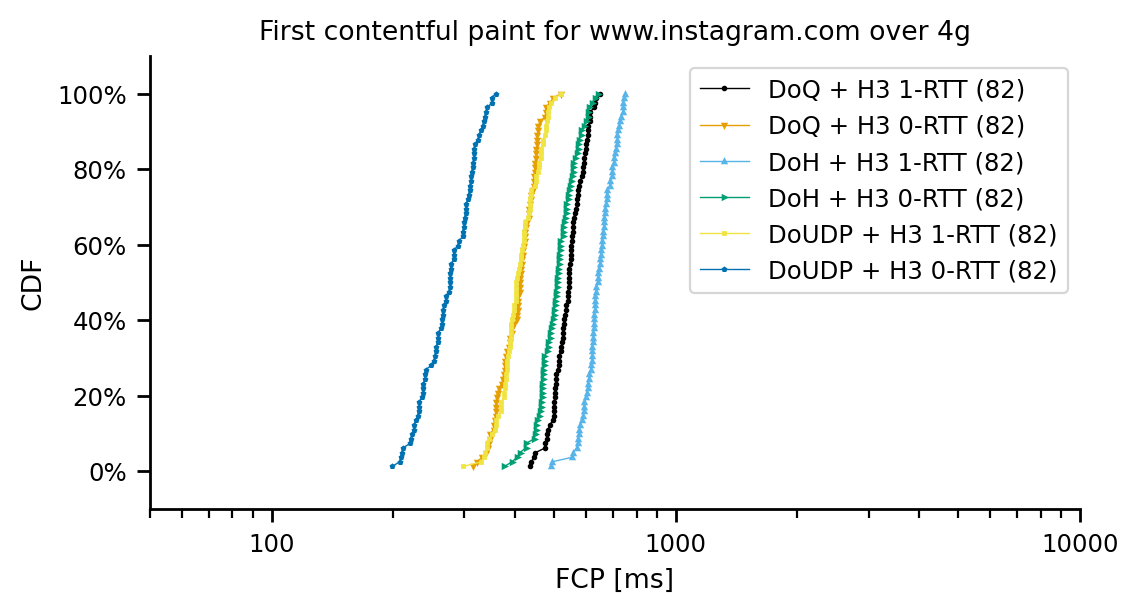

4g-medium
count     83.000000
mean     596.572303
std       47.721028
min      476.412399
10%      534.316958
20%      551.850213
25%      564.108862
30%      565.064231
40%      587.440762
50%      601.060331
60%      608.282442
70%      622.265791
75%      633.469314
80%      637.906557
90%      658.447506
100%     716.155355
max      716.155355
Name: full_fcp, dtype: float64
count     83.000000
mean     424.710857
std       43.449832
min      323.099751
10%      361.665409
20%      387.129549
25%      399.673362
30%      406.811322
40%      422.762227
50%      433.235277
60%      439.206532
70%      446.090261
75%      454.627127
80%      461.230665
90%      470.089547
100%     531.055355
max      531.055355
Name: full_fcp, dtype: float64
count     83.000000
mean     716.624044
std       63.133809
min      578.353225
10%      633.085114
20%      657.845907
25%      665.238142
30%      681.179346
40%      698.935267
50%      710.528469
60%      736.299775
70%      751.399659
75%     

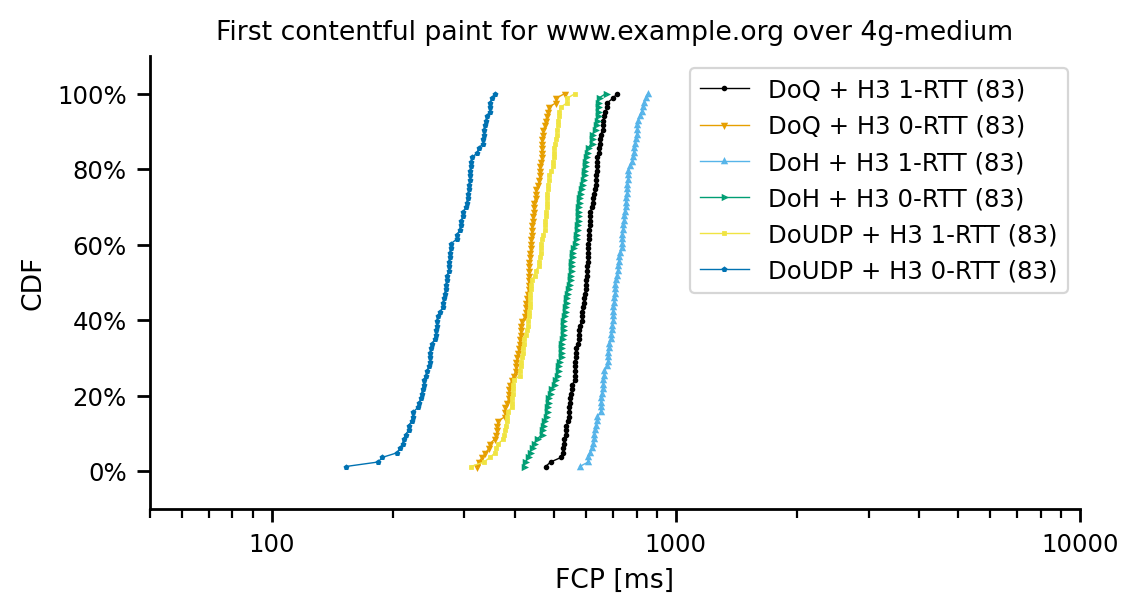

count      82.000000
mean      816.148385
std       102.763914
min       585.676161
10%       697.005590
20%       739.410057
25%       749.979378
30%       757.976694
40%       787.323673
50%       801.206070
60%       825.533132
70%       855.687929
75%       881.455455
80%       895.736997
90%       964.624898
100%     1063.771072
max      1063.771072
Name: full_fcp, dtype: float64
count     82.000000
mean     445.595946
std       47.012011
min      333.718504
10%      384.532576
20%      400.784281
25%      415.641835
30%      420.034195
40%      438.550929
50%      445.054837
60%      455.060898
70%      475.911733
75%      485.329611
80%      489.366648
90%      505.938902
100%     545.388129
max      545.388129
Name: full_fcp, dtype: float64
count      82.000000
mean      931.453831
std       103.341361
min       728.005365
10%       807.418014
20%       831.665550
25%       861.294976
30%       878.286733
40%       901.326899
50%       931.878022
60%       955.475302
70%       

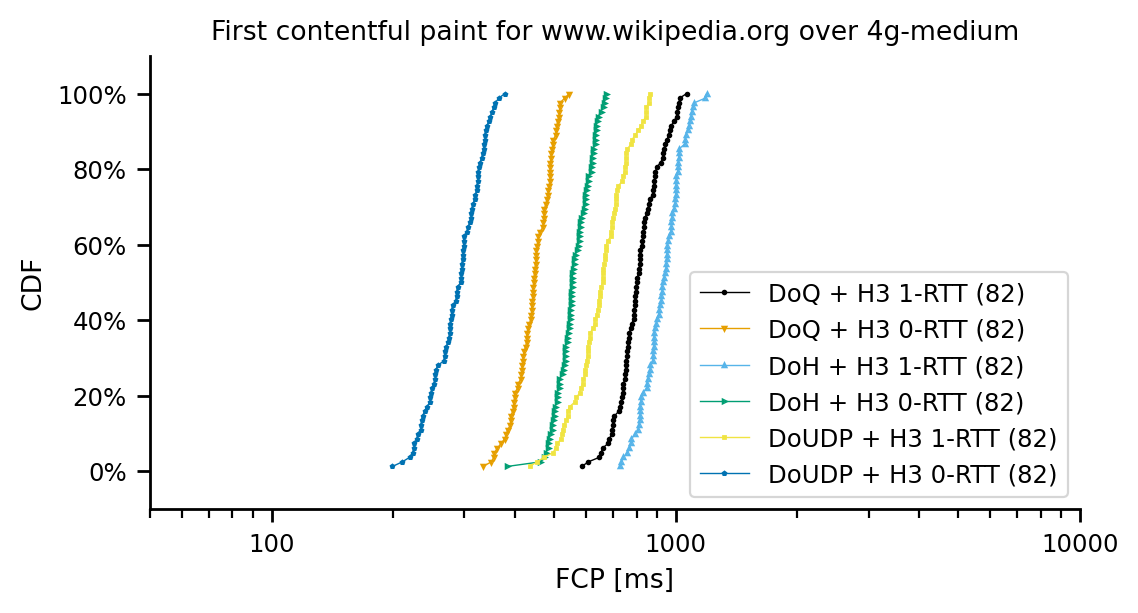

count     82.000000
mean     626.402323
std       45.015825
min      530.057810
10%      570.210085
20%      589.346061
25%      591.884923
30%      597.281360
40%      612.146343
50%      626.753168
60%      637.735354
70%      646.526968
75%      656.331803
80%      671.510434
90%      680.722199
100%     731.626567
max      731.626567
Name: full_fcp, dtype: float64
count     82.000000
mean     470.020616
std       43.802538
min      369.912197
10%      408.402863
20%      430.527660
25%      437.765298
30%      449.520052
40%      460.450691
50%      473.005208
60%      482.905778
70%      497.253023
75%      501.653730
80%      510.225435
90%      521.976116
100%     559.404210
max      559.404210
Name: full_fcp, dtype: float64
count     82.000000
mean     729.981093
std       64.131093
min      554.874846
10%      649.210431
20%      678.830342
25%      686.145146
30%      697.707840
40%      720.299144
50%      739.037381
60%      754.402071
70%      767.408520
75%      775.58500

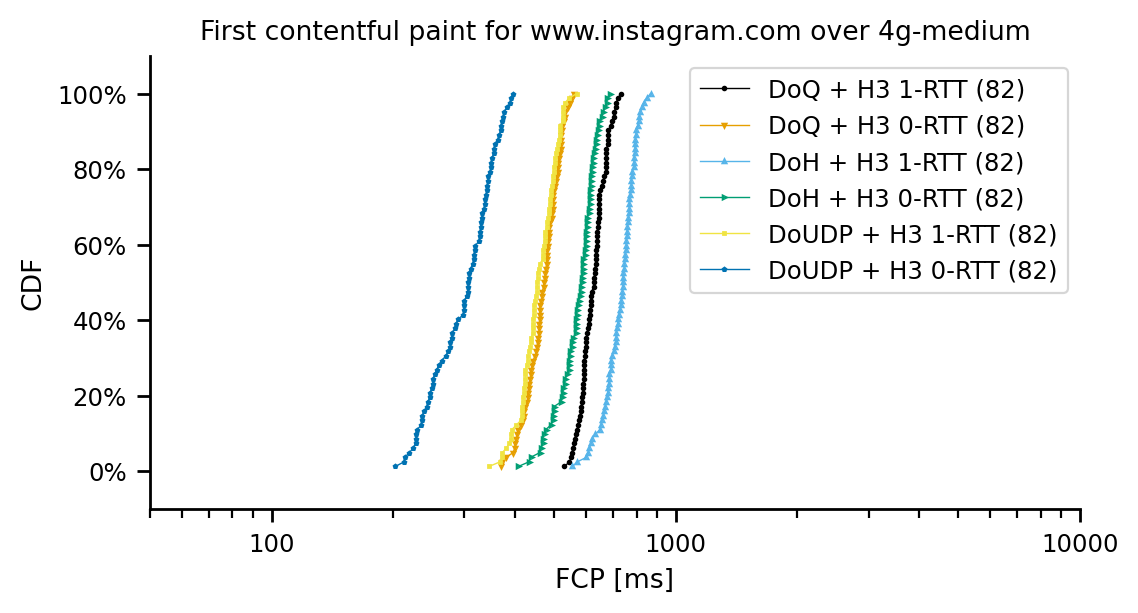

In [31]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_fcp', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_fcp']) == 0:
                    continue
                print(df_tmp['full_fcp'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_fcp'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('First contentful paint for '+website+' over '+access_technology)

        ax.set_xlabel('FCP [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [33]:
df_dns_and_h3.experiment_description.unique()

array(['DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'DoUDP + H3 1-RTT',
       'DoQ + H3 0-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 0-RTT'],
      dtype=object)

In [34]:
df_diff_plt_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_plt'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_plt'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_plt_udp.columns)
            df_diff_plt_udp = df_diff_plt_udp.append(next_df_series, ignore_index=True)
df_diff_plt_udp

,DoQ + H3 0-RTT,DoQ + H3 1-RTT,DoH + H3 1-RTT,experiment_type,website
0,-5.577785,46.848162,60.961489,dsl,www.example.org
1,-56.875382,15.375555,23.945399,dsl,www.wikipedia.org
2,-90.912642,1.724921,2.712072,dsl,www.instagram.com
3,-17.483730,29.492704,44.758706,cable,www.example.org
4,-63.023984,12.724001,19.163045,cable,www.wikipedia.org
5,-91.162323,0.892064,1.455856,cable,www.instagram.com
6,-25.054262,25.299456,37.985679,fiber,www.example.org
7,-72.617409,6.570387,10.018324,fiber,www.wikipedia.org
8,-85.961076,1.161763,2.408112,fiber,www.instagram.com
9,-5.403193,33.861957,59.217642,4g,www.example.org


In [35]:
df_diff_fcp_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_fcp'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_fcp'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_fcp_udp.columns)
            df_diff_fcp_udp = df_diff_fcp_udp.append(next_df_series, ignore_index=True)
df_diff_fcp_udp

,DoQ + H3 0-RTT,DoQ + H3 1-RTT,DoH + H3 1-RTT,experiment_type,website
0,-2.713098,43.467335,58.965580,dsl,www.example.org
1,-43.312427,23.909438,35.883110,dsl,www.wikipedia.org
2,2.922020,34.758730,53.210057,dsl,www.instagram.com
3,-11.726692,31.652756,49.812540,cable,www.example.org
4,-60.149641,15.075254,25.745520,cable,www.wikipedia.org
5,-1.370356,28.346455,42.725545,cable,www.instagram.com
6,-26.007696,21.789446,34.173217,fiber,www.example.org
7,-57.069226,12.164412,19.222581,fiber,www.wikipedia.org
8,-3.446327,19.796936,31.767163,fiber,www.instagram.com
9,-2.066126,33.653685,59.561702,4g,www.example.org


DoQ + H3 0-RTT
count    15.000000
mean    -53.720727
std      34.281222
min     -92.222960
10%     -91.690208
20%     -90.962578
25%     -88.436859
30%     -83.292343
40%     -66.861354
50%     -56.875382
60%     -51.791123
70%     -30.030939
75%     -21.268996
80%     -15.102541
90%      -5.473030
100%     -4.509613
max      -4.509613
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     16.296105
std      14.879563
min       0.892064
10%       1.387026
20%       1.740975
25%       1.835304
30%       2.854574
40%      10.262556
50%      14.436486
60%      15.721875
70%      23.487836
75%      27.396080
80%      30.366555
90%      35.230074
100%     46.848162
max      46.848162
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     25.761633
std      22.625907
min       1.455856
10%       2.529696
20%       2.738860
25%       2.974935
30%       4.567116
40%      15.505157
50%      23.945399
60%      28.027175
70%      36.094338
75%    

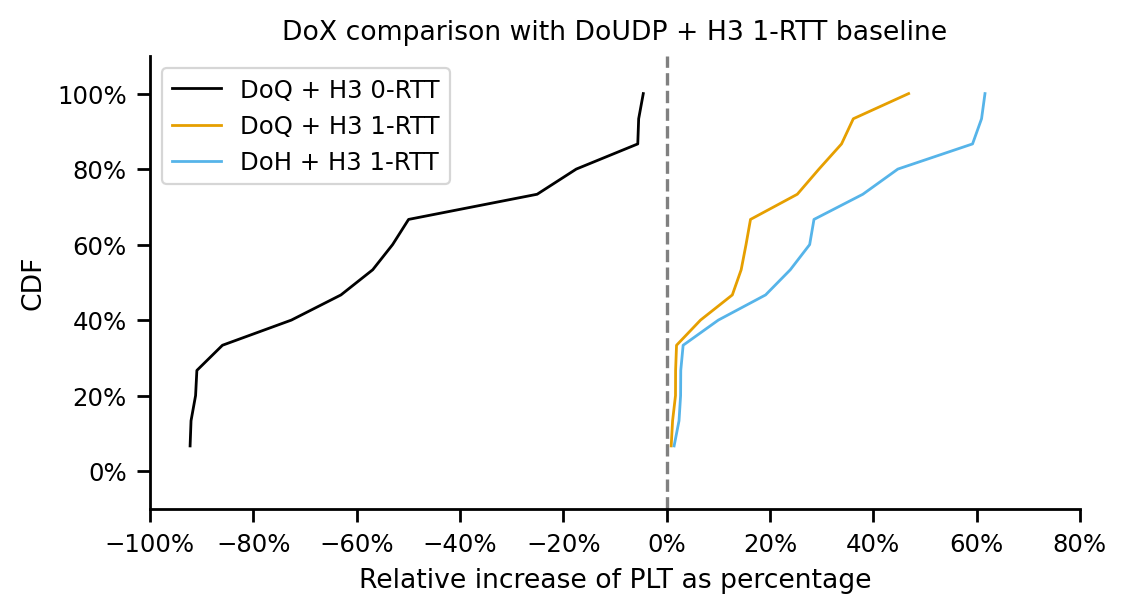

In [38]:
df_tmp = df_diff_plt_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of PLT as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/plt-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/plt-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ + H3 0-RTT
count    15.000000
mean    -18.306264
std      22.943852
min     -60.149641
10%     -51.566506
20%     -41.833171
25%     -36.977232
30%     -31.194426
40%     -17.439093
50%      -3.446327
60%      -2.454309
70%      -1.817491
75%      -1.562844
80%      -0.674938
90%       2.595906
100%      3.948670
max       3.948670
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     27.683118
std       9.168225
min      12.164412
10%      16.963927
20%      20.283638
25%      20.968803
30%      21.583722
40%      23.061441
50%      28.346455
60%      32.453128
70%      34.455331
75%      34.707236
80%      35.067447
90%      37.162924
100%     43.467335
max      43.467335
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     44.698457
std      14.104111
min      19.222581
10%      28.154177
20%      33.692006
25%      34.735838
30%      35.415390
40%      39.165336
50%      42.725545
60%      51.171547
70%      57.814475
75%    

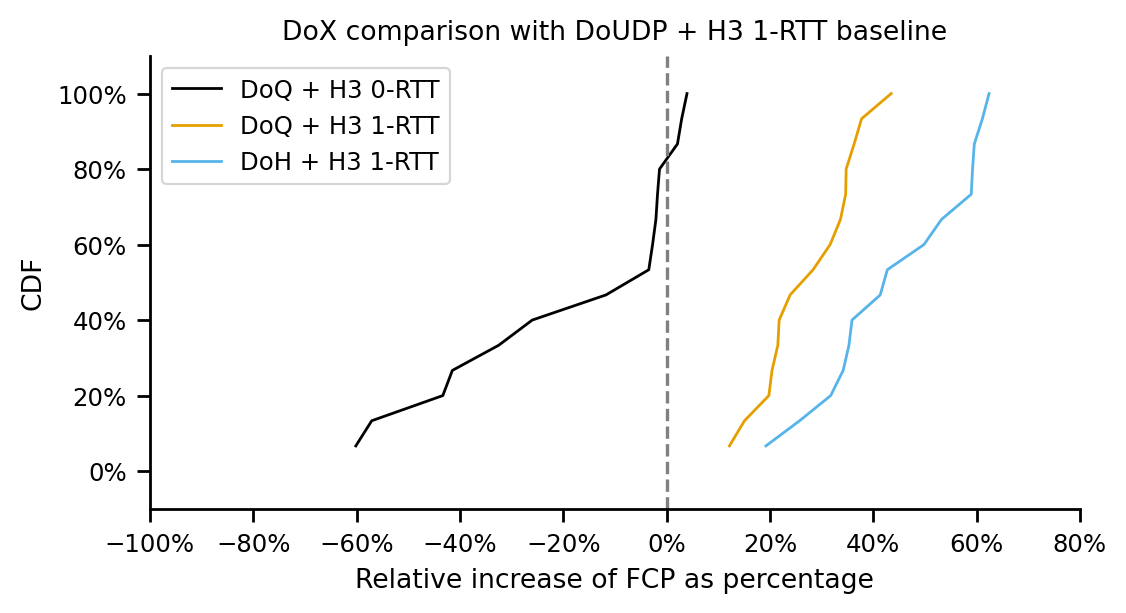

In [39]:
df_tmp = df_diff_fcp_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of FCP as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

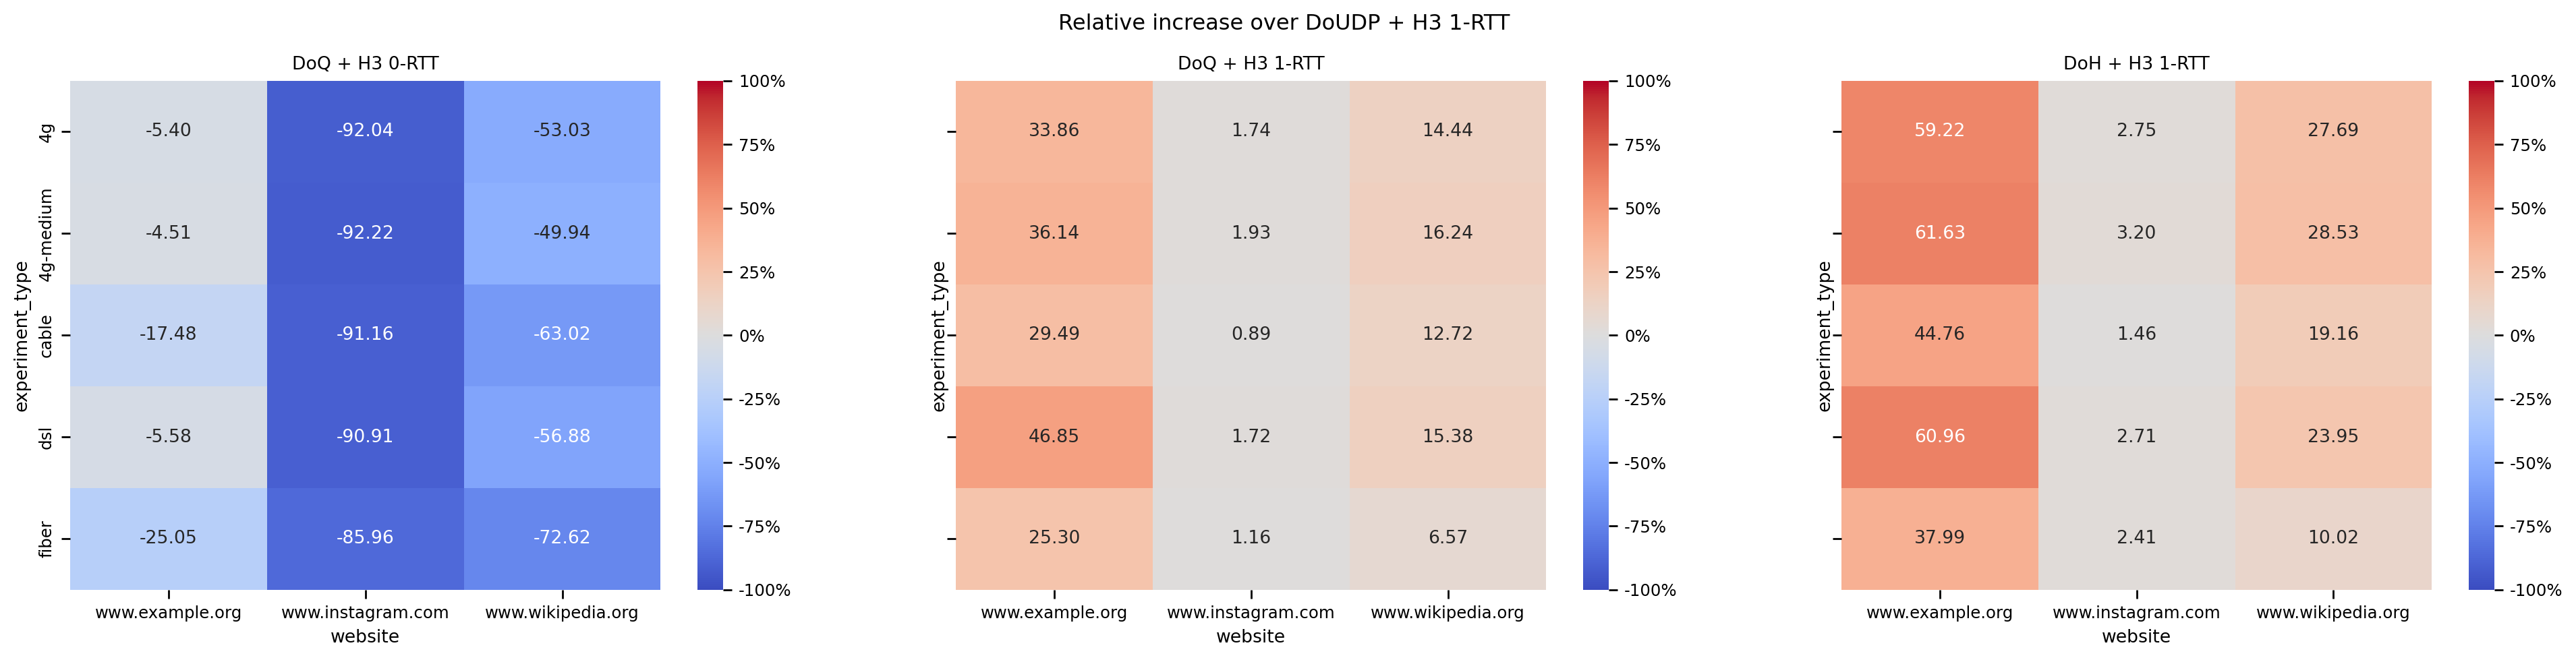

In [81]:
fig, axs = plt.subplots(1, 3, sharex='all', figsize=(24,5), sharey='all')
ax_hm1 =sns.heatmap(df_diff_plt_udp[['DoQ + H3 0-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 0-RTT'), ax=axs.flat[0], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm2 = sns.heatmap(df_diff_plt_udp[['DoQ + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 1-RTT'), ax=axs.flat[1], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm3 = sns.heatmap(df_diff_plt_udp[['DoH + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoH + H3 1-RTT'), ax=axs.flat[2], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
axs.flat[0].set_title('DoQ + H3 0-RTT')
axs.flat[1].set_title('DoQ + H3 1-RTT')
axs.flat[2].set_title('DoH + H3 1-RTT')
fig.suptitle('Relative increase over DoUDP + H3 1-RTT')
ax_hm1.set_yticklabels(labels=ax_hm1.get_yticklabels(), va='center')
plt.show()

In [58]:
df_diff_plt_udp

,DoQ + H3 0-RTT,DoQ + H3 1-RTT,DoH + H3 1-RTT,experiment_type,website
0,-5.577785,46.848162,60.961489,dsl,www.example.org
1,-56.875382,15.375555,23.945399,dsl,www.wikipedia.org
2,-90.912642,1.724921,2.712072,dsl,www.instagram.com
3,-17.483730,29.492704,44.758706,cable,www.example.org
4,-63.023984,12.724001,19.163045,cable,www.wikipedia.org
5,-91.162323,0.892064,1.455856,cable,www.instagram.com
6,-25.054262,25.299456,37.985679,fiber,www.example.org
7,-72.617409,6.570387,10.018324,fiber,www.wikipedia.org
8,-85.961076,1.161763,2.408112,fiber,www.instagram.com
9,-5.403193,33.861957,59.217642,4g,www.example.org
